# Fixation analysis real world and comparison to VR

This code was developed and written by Jasmin L. Walter

In [ ]:
%reset

## Import

In [1]:
import copy  # copy big/deep objects by value
import csv
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import math
import os  # OS operations (read/write files/folders)
import sys
import time
import warnings  # hide warnings
from collections import Counter
from itertools import groupby
import matplotlib
import matplotlib.pyplot as plt  # mother of plots focr Python


# process parallelization
from os.path import exists


# import mlxtend
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
# import pyxdf  # read XDF files (LSL streams recordings)

import scipy.stats
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import Markdown, display  # print nicely
from ipywidgets import IntProgress

from scipy.signal import savgol_coeffs
from tqdm.notebook import tqdm, trange  # mother of progressbars


import scipy.signal
import matplotlib.ticker as ticker

# from matplotlib.pyplot import cm
from cmcrameri import cm

In [2]:
# specify decimals format on pandas tables
# pd.options.display.float_format = "{:.5f}".format

# inline static plotting (default)
%matplotlib inline
# interactive plotting
# %matplotlib widget

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""


def pbar_fork_hack():
    """
    Hack to enforce progress bars to be displayed by fork processes on
    IPython Apps like Jupyter Notebooks.

    Avoids [IPKernelApp] WARNING | WARNING: attempted to send message from fork

    Important: pass this function as argument for the initializer parameter
    while initializing a multiprocessing pool to make it work. E.g.:

    pool = Pool(processes=N_CORES, initializer=pbar_fork_hack)

    Source:
     - https://github.com/ipython/ipython/issues/11049#issue-306086846
     - https://github.com/tqdm/tqdm/issues/485#issuecomment-473338308
    """
    print(" ", end="", flush=True)

In [3]:
# datapaths and savepaths
savepath = "E:/Cyprus_project_overview/data/analysis/exploration/VRvsRealWorld/eyeMovements"


# datapath = "D:/Cyprus_project_overview/store_cyprus_project/eyeTrackingData"
datapathRW = "E:/Cyprus_project_overview/my_data_backup/eye tracking data_backup"

datapathVR_SR = "E:/WestbrookProject/Spa_Re/control_group/pre-processing_2023/velocity_based/step3_gazeProcessing"

datapathVR_HA = "E:/WestbrookProject/HumanA_Data/Experiment1/Exploration_short/pre-processing/velocity_based/step3_gazeProcessing"                


In [4]:
# Getting the Folder without hidden files in ascending order 
data_foldersRW = sorted([f for f in os.listdir(datapathRW) if not f.startswith('TestS')], key=str.lower)

print(data_foldersRW)


['Expl_1_ET_1_2023-09-05_11-56-16_ET', 'Expl_1_ET_2_2023-09-05_12-34-24_ET', 'Expl_1_ET_3_2023-09-05_13-10-01_ET', 'Expl_2_ET_1_2023-09-06_10-36-37_ET', 'Expl_2_ET_2_2023-09-06_11-08-36_ET', 'Expl_2_ET_3_2023-09-06_11-39-21_ET', 'Expl_3_ET_1_2023-09-06_13-24-43_ET', 'Expl_3_ET_2_2023-09-06_13-57-57_ET', 'Expl_3_ET_3_2023-09-06_14-28-39_ET', 'Expl_4_ET_1_2023-09-06_18-31-33_ET', 'Expl_4_ET_2_2023-09-06_18-57-24_ET', 'Expl_5_ET_1_2023-09-07_18-17-19_ET', 'Expl_5_ET_2_2023-09-07_18-48-26_ET']


In [5]:
# Participant list of all participants that participated 5 sessions x 30 min
# in Westbrook city - HumanA version with agents all 22 participants
PartListVR_HA = [365, 1754, 2258, 2693, 3310, 4176, 4597, 4796, 4917, 5741, 6642, 7093, 7412, 7842, 8007, 8469, 8673, 9472, 9502, 9586, 9601]

print(len(PartListVR_HA),'participants in VR HumanA') 

21 participants in VR HumanA


In [6]:
# Participant list of all participants that participated 5 sessions x 30 min
# in Westbrook city
PartListVR_SR = [1004, 1005, 1008, 1010, 1011, 1013, 1017, 1018, 1019, 1021, 1022, 1023, 1054, 1055, 1056, 1057, 1058, 1068, 1069, 1072, 1073, 1074, 1075, 1077, 1079, 1080]

print(len(PartListVR_SR),'participants in VR SpaRe') 

26 participants in VR SpaRe


In [7]:
saveFigures = False

## real world data processing

In [8]:
# slicing info
slicingpath = "E:/Cyprus_project_overview/data"

slicingList = pd.read_csv(os.path.join(slicingpath, "fixation_adj_start_end_ns.csv"))
slicingList.head()

,session,adjusted_start_frame,adjusted_start_timestamp,adjusted_start_timestamp_ns,adjusted_end_frame,adjusted_end_timestamp,adjusted_end_timestamp_ns
0,Expl_1_ET_1_2023-09-05_11-56-16_ET,13670,2023-09-05 09:03:52.544755555,1693904632544755555,32924,2023-09-05 09:14:34.520766666,1693905274520766666
1,Expl_1_ET_2_2023-09-05_12-34-24_ET,9867,2023-09-05 09:39:53.840633333,1693906793840633333,28818,2023-09-05 09:50:25.712655555,1693907425712655555
2,Expl_1_ET_3_2023-09-05_13-10-01_ET,8046,2023-09-05 10:14:30.260911111,1693908870260911111,29536,2023-09-05 10:26:26.792900000,1693909586792900000
3,Expl_2_ET_1_2023-09-06_10-36-37_ET,11600,2023-09-06 07:43:04.403811111,1693986184403811111,30692,2023-09-06 07:53:40.979755555,1693986820979755555
4,Expl_2_ET_2_2023-09-06_11-08-36_ET,8620,2023-09-06 08:13:24.851122222,1693988004851122222,27977,2023-09-06 08:24:10.263077777,1693988650263077777


### Processing Functions

In [9]:
def calculateSaccadeLenths(gazeData):
    
    sDurations = []

    index = gazeData.index.tolist()
    
    startIndex = 0
    firstSample = True
    
    for idx in index:

        if math.isnan(gaze.loc[idx,"fixation id"]):
                    
            # save timestamp of first sample
            if firstSample:
                startIndex = gaze.loc[idx,"timestamp [ns]"]
                firstSample = False
            
            # if it is the last saccade sample or the last sample of the data, save duration and set firstSample True again
            if not (idx == len(index)-1):
                
                if not math.isnan(gaze.loc[idx+1,"fixation id"]):

                    duration = (gaze.loc[idx,"timestamp [ns]"] - startIndex)/1000000
                    sDurations.append(duration)

                    firstSample = True
            else:
                duration = (gaze.loc[idx,"timestamp [ns]"] - startIndex)/1000000
                sDurations.append(duration)
                

    return  sDurations
    

In [10]:
def checkBlinks(gazeData):

    # Filter rows where "blink id" is not NaN -->  select all blink rows
    blink_not_nan = gazeData[gazeData['blink id'].notna()]

    # save the amount of blink rows
    count_all =  len(blink_not_nan)

    # Count how many of these rows have NaN in "fixation id"
    count_nan_fixation = blink_not_nan['fixation id'].isna().sum()

    # Count how many of these rows have non-NaN in "fixation id" aka saccades that are also blinks
    count_not_nan_fixation = blink_not_nan['fixation id'].notna().sum()
    

    # now calcualte the respective durations
    dur_all = blink_not_nan['sampleDuration'].sum()
    dur_nan_fixation = blink_not_nan.loc[blink_not_nan['fixation id'].isna(), 'sampleDuration'].sum()
    dur_not_nan_fixation = blink_not_nan.loc[blink_not_nan['fixation id'].notna(), 'sampleDuration'].sum()
    
    return count_all, count_nan_fixation, count_not_nan_fixation, dur_all, dur_nan_fixation, dur_not_nan_fixation

    

In [11]:
# # # Display head horizontally
# with pd.option_context('display.max_rows', None, 'display.width', 1000):
# # #     display(data_head)
#     display(fullGaze.iloc[191632-10:191632+10])

In [12]:
fixationDurations = []
allFixationDurationsUnsliced = []
saccadeDurations = []
blinkDurations = []

count_blink_rows = []
count_blink_isFix = []
count_blink_notFix = []

durs_blink_rows = []
durs_blink_isFix = []
durs_blink_notFix = []


big_df = []


# files progress bar

folder_pbar = tqdm(
    iterable=data_foldersRW,
    total=len(data_foldersRW),
    desc="📂 ET files____________",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

    # loop necessary for displaying properly the progressbar with multiprocessing
    # source: https://stackoverflow.com/a/40133278

#             info_list = []

for idx,folder in enumerate(folder_pbar):

    print('process files of folder', folder, idx)

    startTS = slicingList.loc[idx, 'adjusted_start_timestamp_ns']
    endTS = slicingList.loc[idx, 'adjusted_end_timestamp_ns']

    # read in data
    fullGaze = pd.read_csv(os.path.join(datapathRW, folder, "gaze.csv"))

    # slice gazes
    gaze = fullGaze[(fullGaze['timestamp [ns]'] >= startTS) & (fullGaze['timestamp [ns]'] <= endTS)].copy()
    gaze = gaze.reset_index(drop=True)

    # add the sample durations
    gaze["sampleDuration"] = gaze["timestamp [ns]"].diff()
    gaze.loc[0, "sampleDuration"] = 0

    # load fixations 
    allFixations = pd.read_csv(os.path.join(datapathRW, folder, "fixations.csv"))
    
    # slice fixations
    fixations = allFixations[(allFixations['start timestamp [ns]'] >= startTS) & (allFixations['end timestamp [ns]'] <= endTS)].copy()
    fixations = fixations.reset_index(drop = True)

    # load blinks
    allBlinks = pd.read_csv(os.path.join(datapathRW, folder, "blinks.csv"))
    # slice blinks
    blinks = allBlinks[(allBlinks['start timestamp [ns]'] >= startTS) & (allBlinks['end timestamp [ns]'] <= endTS)].copy()
    blinks = blinks.reset_index(drop = True)
   
#######################################################################################
    # # use this slicing method if you want to select the "closest" timestamp 
    # ----> we do not use this method here, because we only want to use the data "inside the timestamp boundaries"
    
    # idx_startG = (fullGaze['timestamp [ns]'] - startTS).abs().idxmin()
    # idx_endG = (fullGaze['timestamp [ns]'] - endTS).abs().idxmin()
    # gaze = fullGaze.iloc[idx_startG:idx_endG+1].copy()
    # gaze = gaze.reset_index(drop=True)
    # idx_startF = (allFixations['start timestamp [ns]'] - startTS).abs().idxmin()
    # idx_endF = (allFixations['end timestamp [ns]'] - endTS).abs().idxmin()
    
    # fixations = allFixations.iloc[idx_startF:idx_endF+1].copy()
    # fixations = fixations.reset_index(drop=True)

    # idx_startB = (allBlinks['start timestamp [ns]'] - startTS).abs().idxmin()
    # idx_endB = (allBlinks['end timestamp [ns]'] - endTS).abs().idxmin()
    
    # blinks = allBlinks.iloc[idx_startB:idx_endB+1].copy()
    # blinks = blinks.reset_index(drop=True)
#################################################################################
    
    # extract eye movement variables
    saccDurs = calculateSaccadeLenths(gaze)
    
    fixationDurations.extend(fixations["duration [ms]"])
    allFixationDurationsUnsliced.extend(fixations["duration [ms]"])
    
    saccadeDurations.extend(saccDurs)
    blinkDurations.extend(blinks["duration [ms]"])

    # calcualte the blink statistics
    count_all, count_nan_fixation, count_not_nan_fixation, dur_all, dur_nan_fixation, dur_not_nan_fixation = checkBlinks(gaze)
    
    count_blink_rows.append(count_all)
    count_blink_isFix.append(count_not_nan_fixation)
    count_blink_notFix.append(count_nan_fixation)

    durs_blink_rows.append(dur_all)
    durs_blink_isFix.append(dur_not_nan_fixation)
    durs_blink_notFix.append(dur_nan_fixation)

# ##################################################################
    # now use method from methods paper
    ## Fixation durations ###
    # Only rows with a valid fixation id
    fixation_mask = gaze['fixation id'].notna() & gaze['blink id'].isna()
    fixation_groups = gaze[fixation_mask].groupby('fixation id')
    # Get start/end times and duration
    fixation_durations = fixation_groups['timestamp [ns]'].agg(['first', 'last'])
    fixation_durations['duration_ns'] = (
        fixation_durations['last'] - fixation_durations['first']
    )
    fixation_durations['duration_ms'] = fixation_durations['duration_ns'] / 1e6
    fixation_durations = fixation_durations.reset_index()
    fixation_durations['event'] = 'fixation'
    fixation_durations = fixation_durations.rename(columns={'fixation id': 'event_id'})

    ### Saccade durations ##
    # Saccades = rows with no fixation and no blink
    is_saccade = gaze['fixation id'].isna() & gaze['blink id'].isna()
    # Identify consecutive saccade groups
    saccade_group_id = (is_saccade != is_saccade.shift()).cumsum()
    gaze['saccade id'] = np.where(is_saccade, saccade_group_id, np.nan)
    # Group and compute saccade durations
    saccade_groups = gaze[gaze['saccade id'].notna()].groupby('saccade id')
    saccade_durations = saccade_groups['timestamp [ns]'].agg(['first', 'last'])
    saccade_durations['duration_ns'] = (
        saccade_durations['last'] - saccade_durations['first']
    )
    saccade_durations['duration_ms'] = saccade_durations['duration_ns'] 
    saccade_durations = saccade_durations.reset_index()
    saccade_durations['event'] = 'saccade'
    saccade_durations = saccade_durations.rename(columns={'saccade id': 'event_id'})
    

    ### Combine fixation and saccade events ###
    all_events = pd.concat([fixation_durations, saccade_durations], ignore_index=True)
    
    # Sort all events by start time
    all_events = all_events.sort_values(by='first').reset_index(drop=True)
    # Add session info
    all_events['session'] = folder
    big_df.append(all_events)

# Combine all sessions
big_df = pd.concat(big_df, ignore_index=True)
    
    
print("done")

📄 0 of 13 📂 ET files____________ processed:                                     
              0% ⏱️00:00 ⏳? ⚙…

process files of folder Expl_1_ET_1_2023-09-05_11-56-16_ET 0
process files of folder Expl_1_ET_2_2023-09-05_12-34-24_ET 1
process files of folder Expl_1_ET_3_2023-09-05_13-10-01_ET 2
process files of folder Expl_2_ET_1_2023-09-06_10-36-37_ET 3
process files of folder Expl_2_ET_2_2023-09-06_11-08-36_ET 4
process files of folder Expl_2_ET_3_2023-09-06_11-39-21_ET 5
process files of folder Expl_3_ET_1_2023-09-06_13-24-43_ET 6
process files of folder Expl_3_ET_2_2023-09-06_13-57-57_ET 7
process files of folder Expl_3_ET_3_2023-09-06_14-28-39_ET 8
process files of folder Expl_4_ET_1_2023-09-06_18-31-33_ET 9
process files of folder Expl_4_ET_2_2023-09-06_18-57-24_ET 10
process files of folder Expl_5_ET_1_2023-09-07_18-17-19_ET 11
process files of folder Expl_5_ET_2_2023-09-07_18-48-26_ET 12
done


## VR humanA processing

In [13]:
# Function to extend DataFrame with NaNs
def extend_df(df, target_length):
    current_length = len(df)
    if current_length < target_length:
        additional_rows = target_length - current_length
        extra_df = pd.DataFrame({col: [float('nan')] * additional_rows for col in df.columns})
        df = pd.concat([df, extra_df], ignore_index=True)
    return df

In [14]:
print('start')


gaze_lengthsHA = pd.DataFrame()
saccade_lengthsHA = pd.DataFrame()
noData_lengthsHA = pd.DataFrame()


    
dataLength_overviewHA = pd.DataFrame()



# useful overviews
noFilePartList = [len(PartListVR_HA)]
missingFilesVR_HA = pd.DataFrame(columns=['Participant', 'Session'])



# loop code over all participants in participant list
parts_pbarHA = tqdm(
    iterable=PartListVR_HA,
    total=len(PartListVR_HA),
    desc="participants HA",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPartHA, currentPartHA in enumerate(parts_pbarHA):
#     currentPart = PartList[indexPart]
    print(f'HA: Participant {indexPartHA} - participant ID {currentPartHA}')
    
    gaze_durationsHA = []
    saccade_durationsHA = []
    noD_durationsHA = []
    dataLengthHA = []
        
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(datapathVR_HA) if f.startswith(f'{currentPartHA}_Session_{indexSess}') and f.endswith('_data_processed_gazes.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPartHA], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFilesVR_HA = pd.concat([missingFilesVR_HA, hMF], ignore_index=True)
            

        # runs if files exist

############ Main part starts here ######################################################################################
        # To use it for later!!!
        # based on remodnav --> has almost the same length as our filter

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )



            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for file in file_pbar:

            print('process file ', file)

            # read in data
            dataHA = pd.read_csv(os.path.join(datapathVR_HA, file))
            
            fix_lengthHA = dataHA.loc[dataHA['events'] == 2.0, 'length']
            sacc_lengthHA = dataHA.loc[dataHA['events'] == 1.0, 'length']
            noD_lengthHA =  dataHA.loc[dataHA['events'] == 3.0, 'length']
            
    
            # add durations to overview
            gaze_durationsHA.extend(fix_lengthHA)
            saccade_durationsHA.extend(sacc_lengthHA)
            noD_durationsHA.extend(noD_lengthHA)

            dataLengthHA.append(len(dataHA)) 
                


    # Extend gaze_lengths DataFrame if necessary
    max_length_gazeHA = len(gaze_durationsHA)
    gaze_lengthsHA = extend_df(gaze_lengthsHA, max_length_gazeHA)
    gaze_lengthsHA[currentPartHA] = pd.Series(gaze_durationsHA)

    # Extend saccade_lengths DataFrame if necessary
    max_length_saccadeHA = len(saccade_durationsHA)
    saccade_lengthsHA = extend_df(saccade_lengthsHA, max_length_saccadeHA)
    saccade_lengthsHA[currentPartHA] = pd.Series(saccade_durationsHA)

    # Extend noData_lengths DataFrame if necessary
    max_length_noDataHA = len(noD_durationsHA)
    noData_lengthsHA = extend_df(noData_lengthsHA, max_length_noDataHA)
    noData_lengthsHA[currentPartHA] = pd.Series(noD_durationsHA)

    # Extend dataLength_overview DataFrame if necessary
    max_length_dataLengthHA = len(dataLengthHA)
    dataLength_overviewHA = extend_df(dataLength_overviewHA, max_length_dataLengthHA)
    dataLength_overviewHA[currentPartHA] = pd.Series(dataLengthHA)


start


📄 0 of 21 participants HA processed:                                             
              0% ⏱️00:00 ⏳? …

HA: Participant 0 - participant ID 365


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  365_Session_1_ET_1_data_processed_gazes.csv
process file  365_Session_1_ET_2_data_processed_gazes.csv
process file  365_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  365_Session_2_ET_1_data_processed_gazes.csv
process file  365_Session_2_ET_2_data_processed_gazes.csv
process file  365_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  365_Session_3_ET_1_data_processed_gazes.csv
process file  365_Session_3_ET_2_data_processed_gazes.csv
process file  365_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  365_Session_4_ET_1_data_processed_gazes.csv
process file  365_Session_4_ET_2_data_processed_gazes.csv
process file  365_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  365_Session_5_ET_1_data_processed_gazes.csv
process file  365_Session_5_ET_2_data_processed_gazes.csv
process file  365_Session_5_ET_3_data_processed_gazes.csv
HA: Participant 1 - participant ID 1754


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1754_Session_1_ET_1_data_processed_gazes.csv
process file  1754_Session_1_ET_2_data_processed_gazes.csv
process file  1754_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1754_Session_2_ET_1_data_processed_gazes.csv
process file  1754_Session_2_ET_2_data_processed_gazes.csv
process file  1754_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1754_Session_3_ET_1_data_processed_gazes.csv
process file  1754_Session_3_ET_2_data_processed_gazes.csv
process file  1754_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1754_Session_4_ET_1_data_processed_gazes.csv
process file  1754_Session_4_ET_2_data_processed_gazes.csv
process file  1754_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1754_Session_5_ET_1_data_processed_gazes.csv
process file  1754_Session_5_ET_2_data_processed_gazes.csv
process file  1754_Session_5_ET_3_data_processed_gazes.csv
HA: Participant 2 - participant ID 2258


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  2258_Session_1_ET_1_data_processed_gazes.csv
process file  2258_Session_1_ET_2_data_processed_gazes.csv
process file  2258_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  2258_Session_2_ET_1_data_processed_gazes.csv
process file  2258_Session_2_ET_2_data_processed_gazes.csv
process file  2258_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  2258_Session_3_ET_1_data_processed_gazes.csv
process file  2258_Session_3_ET_2_data_processed_gazes.csv
process file  2258_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  2258_Session_4_ET_1_data_processed_gazes.csv
process file  2258_Session_4_ET_2_data_processed_gazes.csv
process file  2258_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  2258_Session_5_ET_1_data_processed_gazes.csv
process file  2258_Session_5_ET_2_data_processed_gazes.csv
process file  2258_Session_5_ET_3_data_processed_gazes.csv
HA: Participant 3 - participant ID 2693


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  2693_Session_1_ET_1_data_processed_gazes.csv
process file  2693_Session_1_ET_2_data_processed_gazes.csv
process file  2693_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  2693_Session_2_ET_1_data_processed_gazes.csv
process file  2693_Session_2_ET_2_data_processed_gazes.csv
process file  2693_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  2693_Session_3_ET_1_data_processed_gazes.csv
process file  2693_Session_3_ET_2_data_processed_gazes.csv
process file  2693_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  2693_Session_4_ET_1_data_processed_gazes.csv
process file  2693_Session_4_ET_2_data_processed_gazes.csv
process file  2693_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  2693_Session_5_ET_1_data_processed_gazes.csv
process file  2693_Session_5_ET_2_data_processed_gazes.csv
process file  2693_Session_5_ET_3_data_processed_gazes.csv
HA: Participant 4 - participant ID 3310


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  3310_Session_1_ET_1_data_processed_gazes.csv
process file  3310_Session_1_ET_2_data_processed_gazes.csv
process file  3310_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  3310_Session_2_ET_1_data_processed_gazes.csv
process file  3310_Session_2_ET_2_data_processed_gazes.csv
process file  3310_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  3310_Session_3_ET_1_data_processed_gazes.csv
process file  3310_Session_3_ET_2_data_processed_gazes.csv
process file  3310_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  3310_Session_4_ET_1_data_processed_gazes.csv
process file  3310_Session_4_ET_2_data_processed_gazes.csv
process file  3310_Session_4_ET_3_data_processed_gazes.csv
process file  3310_Session_4_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  3310_Session_5_ET_1_data_processed_gazes.csv
process file  3310_Session_5_ET_2_data_processed_gazes.csv
process file  3310_Session_5_ET_3_data_processed_gazes.csv
HA: Participant 5 - participant ID 4176


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4176_Session_1_ET_1_data_processed_gazes.csv
process file  4176_Session_1_ET_2_data_processed_gazes.csv
process file  4176_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4176_Session_2_ET_1_data_processed_gazes.csv
process file  4176_Session_2_ET_2_data_processed_gazes.csv
process file  4176_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4176_Session_3_ET_1_data_processed_gazes.csv
process file  4176_Session_3_ET_2_data_processed_gazes.csv
process file  4176_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4176_Session_4_ET_1_data_processed_gazes.csv
process file  4176_Session_4_ET_2_data_processed_gazes.csv
process file  4176_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4176_Session_5_ET_1_data_processed_gazes.csv
process file  4176_Session_5_ET_2_data_processed_gazes.csv
process file  4176_Session_5_ET_3_data_processed_gazes.csv
HA: Participant 6 - participant ID 4597


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4597_Session_1_ET_1_data_processed_gazes.csv
process file  4597_Session_1_ET_2_data_processed_gazes.csv
process file  4597_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4597_Session_2_ET_1_data_processed_gazes.csv
process file  4597_Session_2_ET_2_data_processed_gazes.csv
process file  4597_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4597_Session_3_ET_1_data_processed_gazes.csv
process file  4597_Session_3_ET_2_data_processed_gazes.csv
process file  4597_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4597_Session_4_ET_1_data_processed_gazes.csv
process file  4597_Session_4_ET_2_data_processed_gazes.csv
process file  4597_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4597_Session_5_ET_1_data_processed_gazes.csv
process file  4597_Session_5_ET_2_data_processed_gazes.csv
process file  4597_Session_5_ET_3_data_processed_gazes.csv
HA: Participant 7 - participant ID 4796


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4796_Session_1_ET_1_data_processed_gazes.csv
process file  4796_Session_1_ET_2_data_processed_gazes.csv
process file  4796_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4796_Session_2_ET_1_data_processed_gazes.csv
process file  4796_Session_2_ET_2_data_processed_gazes.csv
process file  4796_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4796_Session_3_ET_1_data_processed_gazes.csv
process file  4796_Session_3_ET_2_data_processed_gazes.csv
process file  4796_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4796_Session_4_ET_1_data_processed_gazes.csv
process file  4796_Session_4_ET_2_data_processed_gazes.csv
process file  4796_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4796_Session_5_ET_1_data_processed_gazes.csv
process file  4796_Session_5_ET_2_data_processed_gazes.csv
process file  4796_Session_5_ET_3_data_processed_gazes.csv
HA: Participant 8 - participant ID 4917


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4917_Session_1_ET_1_data_processed_gazes.csv
process file  4917_Session_1_ET_2_data_processed_gazes.csv
process file  4917_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4917_Session_2_ET_1_data_processed_gazes.csv
process file  4917_Session_2_ET_2_data_processed_gazes.csv
process file  4917_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4917_Session_3_ET_1_data_processed_gazes.csv
process file  4917_Session_3_ET_2_data_processed_gazes.csv
process file  4917_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4917_Session_4_ET_1_data_processed_gazes.csv
process file  4917_Session_4_ET_2_data_processed_gazes.csv
process file  4917_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  4917_Session_5_ET_1_data_processed_gazes.csv
process file  4917_Session_5_ET_2_data_processed_gazes.csv
process file  4917_Session_5_ET_3_data_processed_gazes.csv
HA: Participant 9 - participant ID 5741


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  5741_Session_1_ET_1_data_processed_gazes.csv
process file  5741_Session_1_ET_2_data_processed_gazes.csv
process file  5741_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  5741_Session_2_ET_1_data_processed_gazes.csv
process file  5741_Session_2_ET_2_data_processed_gazes.csv
process file  5741_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  5741_Session_3_ET_1_data_processed_gazes.csv
process file  5741_Session_3_ET_2_data_processed_gazes.csv
process file  5741_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  5741_Session_4_ET_1_data_processed_gazes.csv
process file  5741_Session_4_ET_2_data_processed_gazes.csv
process file  5741_Session_4_ET_3_data_processed_gazes.csv
process file  5741_Session_4_ET_4_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  5741_Session_5_ET_1_data_processed_gazes.csv
process file  5741_Session_5_ET_2_data_processed_gazes.csv
process file  5741_Session_5_ET_3_data_processed_gazes.csv
process file  5741_Session_5_ET_4_data_processed_gazes.csv
HA: Participant 10 - participant ID 6642


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  6642_Session_1_ET_1_data_processed_gazes.csv
process file  6642_Session_1_ET_2_data_processed_gazes.csv
process file  6642_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  6642_Session_2_ET_1_data_processed_gazes.csv
process file  6642_Session_2_ET_2_data_processed_gazes.csv
process file  6642_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  6642_Session_3_ET_1_data_processed_gazes.csv
process file  6642_Session_3_ET_2_data_processed_gazes.csv
process file  6642_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  6642_Session_4_ET_1_data_processed_gazes.csv
process file  6642_Session_4_ET_2_data_processed_gazes.csv
process file  6642_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  6642_Session_5_ET_1_data_processed_gazes.csv
process file  6642_Session_5_ET_2_data_processed_gazes.csv
process file  6642_Session_5_ET_3_data_processed_gazes.csv
HA: Participant 11 - participant ID 7093


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  7093_Session_1_ET_1_data_processed_gazes.csv
process file  7093_Session_1_ET_2_data_processed_gazes.csv
process file  7093_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  7093_Session_2_ET_1_data_processed_gazes.csv
process file  7093_Session_2_ET_2_data_processed_gazes.csv
process file  7093_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  7093_Session_3_ET_1_data_processed_gazes.csv
process file  7093_Session_3_ET_2_data_processed_gazes.csv
process file  7093_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  7093_Session_4_ET_1_data_processed_gazes.csv
process file  7093_Session_4_ET_2_data_processed_gazes.csv
process file  7093_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  7093_Session_5_ET_1_data_processed_gazes.csv
process file  7093_Session_5_ET_2_data_processed_gazes.csv
process file  7093_Session_5_ET_3_data_processed_gazes.csv
HA: Participant 12 - participant ID 7412


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  7412_Session_1_ET_1_data_processed_gazes.csv
process file  7412_Session_1_ET_2_data_processed_gazes.csv
process file  7412_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  7412_Session_2_ET_1_data_processed_gazes.csv
process file  7412_Session_2_ET_2_data_processed_gazes.csv
process file  7412_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  7412_Session_3_ET_1_data_processed_gazes.csv
process file  7412_Session_3_ET_2_data_processed_gazes.csv
process file  7412_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  7412_Session_4_ET_1_data_processed_gazes.csv
process file  7412_Session_4_ET_2_data_processed_gazes.csv
process file  7412_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  7412_Session_5_ET_1_data_processed_gazes.csv
process file  7412_Session_5_ET_2_data_processed_gazes.csv
process file  7412_Session_5_ET_3_data_processed_gazes.csv
HA: Participant 13 - participant ID 7842


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  7842_Session_1_ET_1_data_processed_gazes.csv
process file  7842_Session_1_ET_2_data_processed_gazes.csv
process file  7842_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  7842_Session_2_ET_1_data_processed_gazes.csv
process file  7842_Session_2_ET_2_data_processed_gazes.csv
process file  7842_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  7842_Session_3_ET_1_data_processed_gazes.csv
process file  7842_Session_3_ET_2_data_processed_gazes.csv
process file  7842_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  7842_Session_4_ET_1_data_processed_gazes.csv
process file  7842_Session_4_ET_2_data_processed_gazes.csv
process file  7842_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  7842_Session_5_ET_1_data_processed_gazes.csv
process file  7842_Session_5_ET_2_data_processed_gazes.csv
process file  7842_Session_5_ET_3_data_processed_gazes.csv
HA: Participant 14 - participant ID 8007


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  8007_Session_1_ET_1_data_processed_gazes.csv
process file  8007_Session_1_ET_2_data_processed_gazes.csv
process file  8007_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  8007_Session_2_ET_1_data_processed_gazes.csv
process file  8007_Session_2_ET_2_data_processed_gazes.csv
process file  8007_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  8007_Session_3_ET_1_data_processed_gazes.csv
process file  8007_Session_3_ET_2_data_processed_gazes.csv
process file  8007_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  8007_Session_4_ET_1_data_processed_gazes.csv
process file  8007_Session_4_ET_2_data_processed_gazes.csv
process file  8007_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  8007_Session_5_ET_1_data_processed_gazes.csv
process file  8007_Session_5_ET_2_data_processed_gazes.csv
process file  8007_Session_5_ET_3_data_processed_gazes.csv
HA: Participant 15 - participant ID 8469


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 4 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  8469_Session_1_ET_1_data_processed_gazes.csv
process file  8469_Session_1_ET_2_data_processed_gazes.csv
process file  8469_Session_1_ET_3_data_processed_gazes.csv
process file  8469_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  8469_Session_2_ET_1_data_processed_gazes.csv
process file  8469_Session_2_ET_2_data_processed_gazes.csv
process file  8469_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  8469_Session_3_ET_1_data_processed_gazes.csv
process file  8469_Session_3_ET_2_data_processed_gazes.csv
process file  8469_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  8469_Session_4_ET_1_data_processed_gazes.csv
process file  8469_Session_4_ET_2_data_processed_gazes.csv
process file  8469_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  8469_Session_5_ET_1_data_processed_gazes.csv
process file  8469_Session_5_ET_2_data_processed_gazes.csv
process file  8469_Session_5_ET_3_data_processed_gazes.csv
HA: Participant 16 - participant ID 8673


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  8673_Session_1_ET_1_data_processed_gazes.csv
process file  8673_Session_1_ET_2_data_processed_gazes.csv
process file  8673_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  8673_Session_2_ET_1_data_processed_gazes.csv
process file  8673_Session_2_ET_2_data_processed_gazes.csv
process file  8673_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  8673_Session_3_ET_1_data_processed_gazes.csv
process file  8673_Session_3_ET_2_data_processed_gazes.csv
process file  8673_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  8673_Session_4_ET_1_data_processed_gazes.csv
process file  8673_Session_4_ET_2_data_processed_gazes.csv
process file  8673_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  8673_Session_5_ET_1_data_processed_gazes.csv
process file  8673_Session_5_ET_2_data_processed_gazes.csv
process file  8673_Session_5_ET_3_data_processed_gazes.csv
HA: Participant 17 - participant ID 9472


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9472_Session_1_ET_1_data_processed_gazes.csv
process file  9472_Session_1_ET_2_data_processed_gazes.csv
process file  9472_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9472_Session_2_ET_1_data_processed_gazes.csv
process file  9472_Session_2_ET_2_data_processed_gazes.csv
process file  9472_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9472_Session_3_ET_1_data_processed_gazes.csv
process file  9472_Session_3_ET_2_data_processed_gazes.csv
process file  9472_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9472_Session_4_ET_1_data_processed_gazes.csv
process file  9472_Session_4_ET_2_data_processed_gazes.csv
process file  9472_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9472_Session_5_ET_1_data_processed_gazes.csv
process file  9472_Session_5_ET_2_data_processed_gazes.csv
process file  9472_Session_5_ET_3_data_processed_gazes.csv
HA: Participant 18 - participant ID 9502


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9502_Session_1_ET_1_data_processed_gazes.csv
process file  9502_Session_1_ET_2_data_processed_gazes.csv
process file  9502_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9502_Session_2_ET_1_data_processed_gazes.csv
process file  9502_Session_2_ET_2_data_processed_gazes.csv
process file  9502_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9502_Session_3_ET_1_data_processed_gazes.csv
process file  9502_Session_3_ET_2_data_processed_gazes.csv
process file  9502_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9502_Session_4_ET_1_data_processed_gazes.csv
process file  9502_Session_4_ET_2_data_processed_gazes.csv
process file  9502_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9502_Session_5_ET_1_data_processed_gazes.csv
process file  9502_Session_5_ET_2_data_processed_gazes.csv
process file  9502_Session_5_ET_3_data_processed_gazes.csv
HA: Participant 19 - participant ID 9586


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9586_Session_1_ET_1_data_processed_gazes.csv
process file  9586_Session_1_ET_2_data_processed_gazes.csv
process file  9586_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9586_Session_2_ET_1_data_processed_gazes.csv
process file  9586_Session_2_ET_2_data_processed_gazes.csv
process file  9586_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9586_Session_3_ET_1_data_processed_gazes.csv
process file  9586_Session_3_ET_2_data_processed_gazes.csv
process file  9586_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9586_Session_4_ET_1_data_processed_gazes.csv
process file  9586_Session_4_ET_2_data_processed_gazes.csv
process file  9586_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9586_Session_5_ET_1_data_processed_gazes.csv
process file  9586_Session_5_ET_2_data_processed_gazes.csv
process file  9586_Session_5_ET_3_data_processed_gazes.csv
HA: Participant 20 - participant ID 9601


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9601_Session_1_ET_1_data_processed_gazes.csv
process file  9601_Session_1_ET_2_data_processed_gazes.csv
process file  9601_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9601_Session_2_ET_1_data_processed_gazes.csv
process file  9601_Session_2_ET_2_data_processed_gazes.csv
process file  9601_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9601_Session_3_ET_1_data_processed_gazes.csv
process file  9601_Session_3_ET_2_data_processed_gazes.csv
process file  9601_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9601_Session_4_ET_1_data_processed_gazes.csv
process file  9601_Session_4_ET_2_data_processed_gazes.csv
process file  9601_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  9601_Session_5_ET_1_data_processed_gazes.csv
process file  9601_Session_5_ET_2_data_processed_gazes.csv
process file  9601_Session_5_ET_3_data_processed_gazes.csv


In [15]:
# Combine gaze durations across all participants
combined_gaze_dataHA = pd.concat([gaze_lengthsHA[col].dropna() for col in gaze_lengthsHA.columns])
combined_gaze_dataHA = combined_gaze_dataHA *1000
# fil_combined_gaze_dataHA = combined_gaze_dataHA < 1000

# Combine saccade durations across all participants
combined_saccade_dataHA = pd.concat([saccade_lengthsHA[col].dropna() for col in saccade_lengthsHA.columns])
combined_saccade_dataHA  = combined_saccade_dataHA *1000
# fil_combined_saccade_dataHA = combined_saccade_dataHA < 1

combined_noData_dataHA = pd.concat([noData_lengthsHA[col].dropna() for col in noData_lengthsHA.columns])
combined_noData_dataHA = combined_noData_dataHA*1000

# Make durations a DataFrame for consistent plotting
fix_dfHA = pd.DataFrame({'duration_ms': combined_gaze_dataHA , 'event': 'fixation'})
sac_dfHA = pd.DataFrame({'duration_ms': combined_saccade_dataHA, 'event': 'saccade'})
comb_dursHA = pd.concat([fix_dfHA, sac_dfHA], ignore_index=True)

# Prefilter to match filtered_df's constraints (e.g., duration < 1000 ms)
comb_durs_filteredHA = comb_dursHA[comb_dursHA["duration_ms"] < 1000]

# fil_combined_noData_dataHA = combined_noData_dataHA < 1

In [16]:
import gc
del dataHA
gc.collect()

118

## VR processing SpaRe data

In [17]:
print('start')


gaze_lengthsSR = pd.DataFrame()
saccade_lengthsSR = pd.DataFrame()
noData_lengthsSR = pd.DataFrame()


    
dataLength_overviewSR = pd.DataFrame()



# useful overviews
noFilePartList = [len(PartListVR_SR)]
missingFilesVR_SR = pd.DataFrame(columns=['Participant', 'Session'])



# loop code over all participants in participant list
parts_pbarSR = tqdm(
    iterable=PartListVR_SR,
    total=len(PartListVR_SR),
    desc="participants SR",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPartSR, currentPartSR in enumerate(parts_pbarSR):
#     currentPart = PartList[indexPart]
    print(f'SR: Participant {indexPartSR} - participant ID {currentPartSR}')
    
    gaze_durationsSR = []
    saccade_durationsSR = []
    noD_durationsSR = []
    dataLengthSR = []
        
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(datapathVR_SR) if f.startswith(f'{currentPartSR}_Session_{indexSess}') and f.endswith('_data_processed_gazes.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPartSR], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFilesVR_SR = pd.concat([missingFilesVR_SR, hMF], ignore_index=True)
            

        # runs if files exist

############ Main part starts here ######################################################################################
        # To use it for later!!!
        # based on remodnav --> has almost the same length as our filter

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )



            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for file in file_pbar:

            print('process file ', file)

            # read in data
            dataSR = pd.read_csv(os.path.join(datapathVR_SR, file))
            
            fix_lengthSR = dataSR.loc[dataSR['events'] == 2.0, 'length']
            sacc_lengthSR = dataSR.loc[dataSR['events'] == 1.0, 'length']
            noD_lengthSR =  dataSR.loc[dataSR['events'] == 3.0, 'length']
            
    
            # add durations to overview
            gaze_durationsSR.extend(fix_lengthSR)
            saccade_durationsSR.extend(sacc_lengthSR)
            noD_durationsSR.extend(noD_lengthSR)

            dataLengthSR.append(len(dataSR)) 
                


    # Extend gaze_lengths DataFrame if necessary
    max_length_gazeSR = len(gaze_durationsSR)
    gaze_lengthsSR = extend_df(gaze_lengthsSR, max_length_gazeSR)
    gaze_lengthsSR[currentPartSR] = pd.Series(gaze_durationsSR)

    # Extend saccade_lengths DataFrame if necessary
    max_length_saccadeSR = len(saccade_durationsSR)
    saccade_lengthsSR = extend_df(saccade_lengthsSR, max_length_saccadeSR)
    saccade_lengthsSR[currentPartSR] = pd.Series(saccade_durationsSR)

    # Extend noData_lengths DataFrame if necessary
    max_length_noDataSR = len(noD_durationsSR)
    noData_lengthsSR = extend_df(noData_lengthsSR, max_length_noDataSR)
    noData_lengthsSR[currentPartSR] = pd.Series(noD_durationsSR)

    # Extend dataLength_overview DataFrame if necessary
    max_length_dataLengthSR = len(dataLengthSR)
    dataLength_overviewSR = extend_df(dataLength_overviewSR, max_length_dataLengthSR)
    dataLength_overviewSR[currentPartSR] = pd.Series(dataLengthSR)


start


📄 0 of 26 participants SR processed:                                             
              0% ⏱️00:00 ⏳? …

SR: Participant 0 - participant ID 1004


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1004_Session_1_ET_1_data_processed_gazes.csv
process file  1004_Session_1_ET_2_data_processed_gazes.csv
process file  1004_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1004_Session_2_ET_1_data_processed_gazes.csv
process file  1004_Session_2_ET_2_data_processed_gazes.csv
process file  1004_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1004_Session_3_ET_1_data_processed_gazes.csv
process file  1004_Session_3_ET_2_data_processed_gazes.csv
process file  1004_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1004_Session_4_ET_1_data_processed_gazes.csv
process file  1004_Session_4_ET_2_data_processed_gazes.csv
process file  1004_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1004_Session_5_ET_1_data_processed_gazes.csv
process file  1004_Session_5_ET_2_data_processed_gazes.csv
process file  1004_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 1 - participant ID 1005


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1005_Session_1_ET_1_data_processed_gazes.csv
process file  1005_Session_1_ET_2_data_processed_gazes.csv
process file  1005_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1005_Session_2_ET_1_data_processed_gazes.csv
process file  1005_Session_2_ET_2_data_processed_gazes.csv
process file  1005_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1005_Session_3_ET_1_data_processed_gazes.csv
process file  1005_Session_3_ET_2_data_processed_gazes.csv
process file  1005_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1005_Session_4_ET_1_data_processed_gazes.csv
process file  1005_Session_4_ET_2_data_processed_gazes.csv
process file  1005_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1005_Session_5_ET_1_data_processed_gazes.csv
process file  1005_Session_5_ET_2_data_processed_gazes.csv
process file  1005_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 2 - participant ID 1008


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1008_Session_1_ET_1_data_processed_gazes.csv
process file  1008_Session_1_ET_2_data_processed_gazes.csv
process file  1008_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1008_Session_2_ET_1_data_processed_gazes.csv
process file  1008_Session_2_ET_2_data_processed_gazes.csv
process file  1008_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1008_Session_3_ET_1_data_processed_gazes.csv
process file  1008_Session_3_ET_2_data_processed_gazes.csv
process file  1008_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1008_Session_4_ET_1_data_processed_gazes.csv
process file  1008_Session_4_ET_2_data_processed_gazes.csv
process file  1008_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1008_Session_5_ET_1_data_processed_gazes.csv
process file  1008_Session_5_ET_2_data_processed_gazes.csv
process file  1008_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 3 - participant ID 1010


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 4 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1010_Session_1_ET_1_data_processed_gazes.csv
process file  1010_Session_1_ET_2_data_processed_gazes.csv
process file  1010_Session_1_ET_3_data_processed_gazes.csv
process file  1010_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1010_Session_2_ET_1_data_processed_gazes.csv
process file  1010_Session_2_ET_2_data_processed_gazes.csv
process file  1010_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1010_Session_3_ET_1_data_processed_gazes.csv
process file  1010_Session_3_ET_2_data_processed_gazes.csv
process file  1010_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1010_Session_4_ET_1_data_processed_gazes.csv
process file  1010_Session_4_ET_2_data_processed_gazes.csv
process file  1010_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1010_Session_5_ET_1_data_processed_gazes.csv
process file  1010_Session_5_ET_2_data_processed_gazes.csv
process file  1010_Session_5_ET_3_data_processed_gazes.csv
process file  1010_Session_5_ET_4_data_processed_gazes.csv
SR: Participant 4 - participant ID 1011


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 4 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1011_Session_1_ET_1_data_processed_gazes.csv
process file  1011_Session_1_ET_2_data_processed_gazes.csv
process file  1011_Session_1_ET_3_data_processed_gazes.csv
process file  1011_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1011_Session_2_ET_1_data_processed_gazes.csv
process file  1011_Session_2_ET_2_data_processed_gazes.csv
process file  1011_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1011_Session_3_ET_1_data_processed_gazes.csv
process file  1011_Session_3_ET_2_data_processed_gazes.csv
process file  1011_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1011_Session_4_ET_1_data_processed_gazes.csv
process file  1011_Session_4_ET_2_data_processed_gazes.csv
process file  1011_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1011_Session_5_ET_1_data_processed_gazes.csv
process file  1011_Session_5_ET_2_data_processed_gazes.csv
process file  1011_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 5 - participant ID 1013


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1013_Session_1_ET_1_data_processed_gazes.csv
process file  1013_Session_1_ET_2_data_processed_gazes.csv
process file  1013_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1013_Session_2_ET_1_data_processed_gazes.csv
process file  1013_Session_2_ET_2_data_processed_gazes.csv
process file  1013_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1013_Session_3_ET_1_data_processed_gazes.csv
process file  1013_Session_3_ET_2_data_processed_gazes.csv
process file  1013_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1013_Session_4_ET_1_data_processed_gazes.csv
process file  1013_Session_4_ET_2_data_processed_gazes.csv
process file  1013_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1013_Session_5_ET_1_data_processed_gazes.csv
process file  1013_Session_5_ET_2_data_processed_gazes.csv
process file  1013_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 6 - participant ID 1017


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 5 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1017_Session_1_ET_1_data_processed_gazes.csv
process file  1017_Session_1_ET_2_data_processed_gazes.csv
process file  1017_Session_1_ET_3_data_processed_gazes.csv
process file  1017_Session_1_ET_4_data_processed_gazes.csv
process file  1017_Session_1_ET_5_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1017_Session_2_ET_1_data_processed_gazes.csv
process file  1017_Session_2_ET_2_data_processed_gazes.csv
process file  1017_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1017_Session_3_ET_1_data_processed_gazes.csv
process file  1017_Session_3_ET_2_data_processed_gazes.csv
process file  1017_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1017_Session_4_ET_1_data_processed_gazes.csv
process file  1017_Session_4_ET_2_data_processed_gazes.csv
process file  1017_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1017_Session_5_ET_1_data_processed_gazes.csv
process file  1017_Session_5_ET_2_data_processed_gazes.csv
process file  1017_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 7 - participant ID 1018


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 4 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1018_Session_1_ET_1_data_processed_gazes.csv
process file  1018_Session_1_ET_2_data_processed_gazes.csv
process file  1018_Session_1_ET_3_data_processed_gazes.csv
process file  1018_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1018_Session_2_ET_1_data_processed_gazes.csv
process file  1018_Session_2_ET_2_data_processed_gazes.csv
process file  1018_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1018_Session_3_ET_1_data_processed_gazes.csv
process file  1018_Session_3_ET_2_data_processed_gazes.csv
process file  1018_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1018_Session_4_ET_1_data_processed_gazes.csv
process file  1018_Session_4_ET_2_data_processed_gazes.csv
process file  1018_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1018_Session_5_ET_1_data_processed_gazes.csv
process file  1018_Session_5_ET_2_data_processed_gazes.csv
process file  1018_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 8 - participant ID 1019


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1019_Session_1_ET_1_data_processed_gazes.csv
process file  1019_Session_1_ET_2_data_processed_gazes.csv
process file  1019_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1019_Session_2_ET_1_data_processed_gazes.csv
process file  1019_Session_2_ET_2_data_processed_gazes.csv
process file  1019_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1019_Session_3_ET_1_data_processed_gazes.csv
process file  1019_Session_3_ET_2_data_processed_gazes.csv
process file  1019_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1019_Session_4_ET_1_data_processed_gazes.csv
process file  1019_Session_4_ET_2_data_processed_gazes.csv
process file  1019_Session_4_ET_3_data_processed_gazes.csv
process file  1019_Session_4_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1019_Session_5_ET_1_data_processed_gazes.csv
process file  1019_Session_5_ET_2_data_processed_gazes.csv
process file  1019_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 9 - participant ID 1021


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1021_Session_1_ET_1_data_processed_gazes.csv
process file  1021_Session_1_ET_2_data_processed_gazes.csv
process file  1021_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1021_Session_2_ET_1_data_processed_gazes.csv
process file  1021_Session_2_ET_2_data_processed_gazes.csv
process file  1021_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1021_Session_3_ET_1_data_processed_gazes.csv
process file  1021_Session_3_ET_2_data_processed_gazes.csv
process file  1021_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1021_Session_4_ET_1_data_processed_gazes.csv
process file  1021_Session_4_ET_2_data_processed_gazes.csv
process file  1021_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1021_Session_5_ET_1_data_processed_gazes.csv
process file  1021_Session_5_ET_2_data_processed_gazes.csv
process file  1021_Session_5_ET_3_data_processed_gazes.csv
process file  1021_Session_5_ET_4_data_processed_gazes.csv
SR: Participant 10 - participant ID 1022


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1022_Session_1_ET_1_data_processed_gazes.csv
process file  1022_Session_1_ET_2_data_processed_gazes.csv
process file  1022_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1022_Session_2_ET_1_data_processed_gazes.csv
process file  1022_Session_2_ET_2_data_processed_gazes.csv
process file  1022_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1022_Session_3_ET_1_data_processed_gazes.csv
process file  1022_Session_3_ET_2_data_processed_gazes.csv
process file  1022_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1022_Session_4_ET_1_data_processed_gazes.csv
process file  1022_Session_4_ET_2_data_processed_gazes.csv
process file  1022_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1022_Session_5_ET_1_data_processed_gazes.csv
process file  1022_Session_5_ET_2_data_processed_gazes.csv
process file  1022_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 11 - participant ID 1023


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1023_Session_1_ET_1_data_processed_gazes.csv
process file  1023_Session_1_ET_2_data_processed_gazes.csv
process file  1023_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1023_Session_2_ET_1_data_processed_gazes.csv
process file  1023_Session_2_ET_2_data_processed_gazes.csv
process file  1023_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1023_Session_3_ET_1_data_processed_gazes.csv
process file  1023_Session_3_ET_2_data_processed_gazes.csv
process file  1023_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1023_Session_4_ET_1_data_processed_gazes.csv
process file  1023_Session_4_ET_2_data_processed_gazes.csv
process file  1023_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1023_Session_5_ET_1_data_processed_gazes.csv
process file  1023_Session_5_ET_2_data_processed_gazes.csv
process file  1023_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 12 - participant ID 1054


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1054_Session_1_ET_1_data_processed_gazes.csv
process file  1054_Session_1_ET_2_data_processed_gazes.csv
process file  1054_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1054_Session_2_ET_1_data_processed_gazes.csv
process file  1054_Session_2_ET_2_data_processed_gazes.csv
process file  1054_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1054_Session_3_ET_1_data_processed_gazes.csv
process file  1054_Session_3_ET_2_data_processed_gazes.csv
process file  1054_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1054_Session_4_ET_1_data_processed_gazes.csv
process file  1054_Session_4_ET_2_data_processed_gazes.csv
process file  1054_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1054_Session_5_ET_1_data_processed_gazes.csv
process file  1054_Session_5_ET_2_data_processed_gazes.csv
process file  1054_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 13 - participant ID 1055


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1055_Session_1_ET_1_data_processed_gazes.csv
process file  1055_Session_1_ET_2_data_processed_gazes.csv
process file  1055_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1055_Session_2_ET_1_data_processed_gazes.csv
process file  1055_Session_2_ET_2_data_processed_gazes.csv
process file  1055_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1055_Session_3_ET_1_data_processed_gazes.csv
process file  1055_Session_3_ET_2_data_processed_gazes.csv
process file  1055_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1055_Session_4_ET_1_data_processed_gazes.csv
process file  1055_Session_4_ET_2_data_processed_gazes.csv
process file  1055_Session_4_ET_3_data_processed_gazes.csv
process file  1055_Session_4_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1055_Session_5_ET_1_data_processed_gazes.csv
process file  1055_Session_5_ET_2_data_processed_gazes.csv
process file  1055_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 14 - participant ID 1056


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1056_Session_1_ET_1_data_processed_gazes.csv
process file  1056_Session_1_ET_2_data_processed_gazes.csv
process file  1056_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1056_Session_2_ET_1_data_processed_gazes.csv
process file  1056_Session_2_ET_2_data_processed_gazes.csv
process file  1056_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1056_Session_3_ET_1_data_processed_gazes.csv
process file  1056_Session_3_ET_2_data_processed_gazes.csv
process file  1056_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1056_Session_4_ET_1_data_processed_gazes.csv
process file  1056_Session_4_ET_2_data_processed_gazes.csv
process file  1056_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1056_Session_5_ET_1_data_processed_gazes.csv
process file  1056_Session_5_ET_2_data_processed_gazes.csv
process file  1056_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 15 - participant ID 1057


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1057_Session_1_ET_1_data_processed_gazes.csv
process file  1057_Session_1_ET_2_data_processed_gazes.csv
process file  1057_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1057_Session_2_ET_1_data_processed_gazes.csv
process file  1057_Session_2_ET_2_data_processed_gazes.csv
process file  1057_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1057_Session_3_ET_1_data_processed_gazes.csv
process file  1057_Session_3_ET_2_data_processed_gazes.csv
process file  1057_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1057_Session_4_ET_1_data_processed_gazes.csv
process file  1057_Session_4_ET_2_data_processed_gazes.csv
process file  1057_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1057_Session_5_ET_1_data_processed_gazes.csv
process file  1057_Session_5_ET_2_data_processed_gazes.csv
process file  1057_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 16 - participant ID 1058


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 4 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1058_Session_1_ET_1_data_processed_gazes.csv
process file  1058_Session_1_ET_2_data_processed_gazes.csv
process file  1058_Session_1_ET_3_data_processed_gazes.csv
process file  1058_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1058_Session_2_ET_1_data_processed_gazes.csv
process file  1058_Session_2_ET_2_data_processed_gazes.csv
process file  1058_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1058_Session_3_ET_1_data_processed_gazes.csv
process file  1058_Session_3_ET_2_data_processed_gazes.csv
process file  1058_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1058_Session_4_ET_1_data_processed_gazes.csv
process file  1058_Session_4_ET_2_data_processed_gazes.csv
process file  1058_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1058_Session_5_ET_1_data_processed_gazes.csv
process file  1058_Session_5_ET_2_data_processed_gazes.csv
process file  1058_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 17 - participant ID 1068


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 4 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1068_Session_1_ET_1_data_processed_gazes.csv
process file  1068_Session_1_ET_2_data_processed_gazes.csv
process file  1068_Session_1_ET_3_data_processed_gazes.csv
process file  1068_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1068_Session_2_ET_1_data_processed_gazes.csv
process file  1068_Session_2_ET_2_data_processed_gazes.csv
process file  1068_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1068_Session_3_ET_1_data_processed_gazes.csv
process file  1068_Session_3_ET_2_data_processed_gazes.csv
process file  1068_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1068_Session_4_ET_1_data_processed_gazes.csv
process file  1068_Session_4_ET_2_data_processed_gazes.csv
process file  1068_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1068_Session_5_ET_1_data_processed_gazes.csv
process file  1068_Session_5_ET_2_data_processed_gazes.csv
process file  1068_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 18 - participant ID 1069


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1069_Session_1_ET_1_data_processed_gazes.csv
process file  1069_Session_1_ET_2_data_processed_gazes.csv
process file  1069_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1069_Session_2_ET_1_data_processed_gazes.csv
process file  1069_Session_2_ET_2_data_processed_gazes.csv
process file  1069_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1069_Session_3_ET_1_data_processed_gazes.csv
process file  1069_Session_3_ET_2_data_processed_gazes.csv
process file  1069_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1069_Session_4_ET_1_data_processed_gazes.csv
process file  1069_Session_4_ET_2_data_processed_gazes.csv
process file  1069_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1069_Session_5_ET_1_data_processed_gazes.csv
process file  1069_Session_5_ET_2_data_processed_gazes.csv
process file  1069_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 19 - participant ID 1072


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1072_Session_1_ET_1_data_processed_gazes.csv
process file  1072_Session_1_ET_2_data_processed_gazes.csv
process file  1072_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1072_Session_2_ET_1_data_processed_gazes.csv
process file  1072_Session_2_ET_2_data_processed_gazes.csv
process file  1072_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1072_Session_3_ET_1_data_processed_gazes.csv
process file  1072_Session_3_ET_2_data_processed_gazes.csv
process file  1072_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1072_Session_4_ET_1_data_processed_gazes.csv
process file  1072_Session_4_ET_2_data_processed_gazes.csv
process file  1072_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1072_Session_5_ET_1_data_processed_gazes.csv
process file  1072_Session_5_ET_2_data_processed_gazes.csv
process file  1072_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 20 - participant ID 1073


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1073_Session_1_ET_1_data_processed_gazes.csv
process file  1073_Session_1_ET_2_data_processed_gazes.csv
process file  1073_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1073_Session_2_ET_1_data_processed_gazes.csv
process file  1073_Session_2_ET_2_data_processed_gazes.csv
process file  1073_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1073_Session_3_ET_1_data_processed_gazes.csv
process file  1073_Session_3_ET_2_data_processed_gazes.csv
process file  1073_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1073_Session_4_ET_1_data_processed_gazes.csv
process file  1073_Session_4_ET_2_data_processed_gazes.csv
process file  1073_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1073_Session_5_ET_1_data_processed_gazes.csv
process file  1073_Session_5_ET_2_data_processed_gazes.csv
process file  1073_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 21 - participant ID 1074


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1074_Session_1_ET_1_data_processed_gazes.csv
process file  1074_Session_1_ET_2_data_processed_gazes.csv
process file  1074_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1074_Session_2_ET_1_data_processed_gazes.csv
process file  1074_Session_2_ET_2_data_processed_gazes.csv
process file  1074_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1074_Session_3_ET_1_data_processed_gazes.csv
process file  1074_Session_3_ET_2_data_processed_gazes.csv
process file  1074_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1074_Session_4_ET_1_data_processed_gazes.csv
process file  1074_Session_4_ET_2_data_processed_gazes.csv
process file  1074_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1074_Session_5_ET_1_data_processed_gazes.csv
process file  1074_Session_5_ET_2_data_processed_gazes.csv
process file  1074_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 22 - participant ID 1075


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1075_Session_1_ET_1_data_processed_gazes.csv
process file  1075_Session_1_ET_2_data_processed_gazes.csv
process file  1075_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1075_Session_2_ET_1_data_processed_gazes.csv
process file  1075_Session_2_ET_2_data_processed_gazes.csv
process file  1075_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1075_Session_3_ET_1_data_processed_gazes.csv
process file  1075_Session_3_ET_2_data_processed_gazes.csv
process file  1075_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1075_Session_4_ET_1_data_processed_gazes.csv
process file  1075_Session_4_ET_2_data_processed_gazes.csv
process file  1075_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1075_Session_5_ET_1_data_processed_gazes.csv
process file  1075_Session_5_ET_2_data_processed_gazes.csv
process file  1075_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 23 - participant ID 1077


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1077_Session_1_ET_1_data_processed_gazes.csv
process file  1077_Session_1_ET_2_data_processed_gazes.csv
process file  1077_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1077_Session_2_ET_1_data_processed_gazes.csv
process file  1077_Session_2_ET_2_data_processed_gazes.csv
process file  1077_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1077_Session_3_ET_1_data_processed_gazes.csv
process file  1077_Session_3_ET_2_data_processed_gazes.csv
process file  1077_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1077_Session_4_ET_1_data_processed_gazes.csv
process file  1077_Session_4_ET_2_data_processed_gazes.csv
process file  1077_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1077_Session_5_ET_1_data_processed_gazes.csv
process file  1077_Session_5_ET_2_data_processed_gazes.csv
process file  1077_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 24 - participant ID 1079


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1079_Session_1_ET_1_data_processed_gazes.csv
process file  1079_Session_1_ET_2_data_processed_gazes.csv
process file  1079_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1079_Session_2_ET_1_data_processed_gazes.csv
process file  1079_Session_2_ET_2_data_processed_gazes.csv
process file  1079_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1079_Session_3_ET_1_data_processed_gazes.csv
process file  1079_Session_3_ET_2_data_processed_gazes.csv
process file  1079_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1079_Session_4_ET_1_data_processed_gazes.csv
process file  1079_Session_4_ET_2_data_processed_gazes.csv
process file  1079_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1079_Session_5_ET_1_data_processed_gazes.csv
process file  1079_Session_5_ET_2_data_processed_gazes.csv
process file  1079_Session_5_ET_3_data_processed_gazes.csv
SR: Participant 25 - participant ID 1080


📄 0 of 5 sessions________ processed:                                             
              0% ⏱️00:00 ⏳? …

📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1080_Session_1_ET_1_data_processed_gazes.csv
process file  1080_Session_1_ET_2_data_processed_gazes.csv
process file  1080_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1080_Session_2_ET_1_data_processed_gazes.csv
process file  1080_Session_2_ET_2_data_processed_gazes.csv
process file  1080_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1080_Session_3_ET_1_data_processed_gazes.csv
process file  1080_Session_3_ET_2_data_processed_gazes.csv
process file  1080_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1080_Session_4_ET_1_data_processed_gazes.csv
process file  1080_Session_4_ET_2_data_processed_gazes.csv
process file  1080_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:                                      
              0% ⏱️00:00 ⏳? ⚙…

process file  1080_Session_5_ET_1_data_processed_gazes.csv
process file  1080_Session_5_ET_2_data_processed_gazes.csv
process file  1080_Session_5_ET_3_data_processed_gazes.csv


In [18]:
# Combine gaze durations across all participants
combined_gaze_dataSR = pd.concat([gaze_lengthsSR[col].dropna() for col in gaze_lengthsSR.columns])
combined_gaze_dataSR = combined_gaze_dataSR *1000
# fil_combined_gaze_dataSR = combined_gaze_dataSR < 1000

# Combine saccade durations across all participants
combined_saccade_dataSR = pd.concat([saccade_lengthsSR[col].dropna() for col in saccade_lengthsSR.columns])
combined_saccade_dataSR  = combined_saccade_dataSR *1000
# fil_combined_saccade_dataSR = combined_saccade_dataSR < 1

combined_noData_dataSR = pd.concat([noData_lengthsSR[col].dropna() for col in noData_lengthsSR.columns])
combined_noData_dataSR = combined_noData_dataSR*1000

# Make durations a DataFrame for consistent plotting
fix_dfSR = pd.DataFrame({'duration_ms': combined_gaze_dataSR , 'event': 'fixation'})
sac_dfSR = pd.DataFrame({'duration_ms': combined_saccade_dataSR, 'event': 'saccade'})
comb_dursSR = pd.concat([fix_dfSR, sac_dfSR], ignore_index=True)

# Prefilter to match filtered_df's constraints (e.g., duration < 1000 ms)
comb_durs_filteredSR = comb_dursSR[comb_dursSR["duration_ms"] < 1000]

# fil_combined_noData_dataSR = combined_noData_dataSR < 1

In [19]:
# how do I need to adapt this if instead of creating bins for data from 0 - 1000 it should work for data from 0-1 bins = np.linspace(0, 1000, 101)  # 100 bins, 101 edges
# Hi chat, in the following code you can see that I am plotting fixation/gaze and saccade durations in a histogram and before doing so, I just accumulate all participants, so essentiall using the data independent of which participant produced it. Instead, I want to create a histogram that represents the mean duration in each bin 


In [20]:
print(combined_gaze_dataHA[:5])

0    388.888889
1     88.888889
2    288.888889
3    255.555556
4    211.111111
dtype: float64


## eye movement duration distribution

In [21]:
# set figure style
# sns.set_style('ticks')


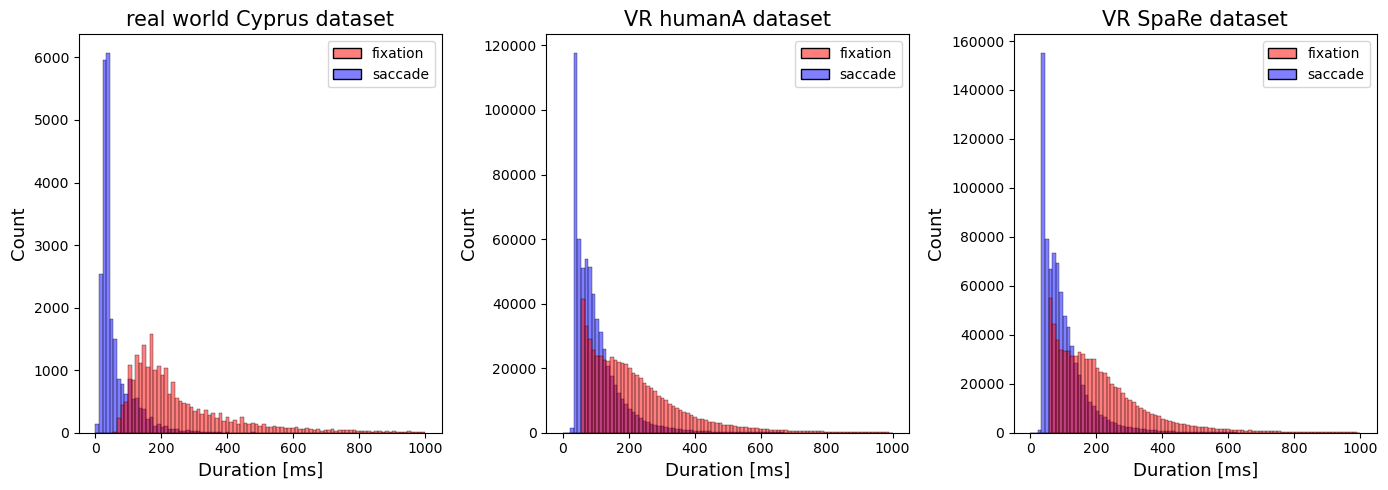

In [22]:
# filter the data sources to only plot everything below 1 sec of duration
bins = np.linspace(0, 1000, 101)  # 100 bins, 101 edges
binsHA = np.linspace(0, 1000, 92)  # 100 bins, 101 edges


# Make durations a DataFrame for consistent plotting
fix_df = pd.DataFrame({'duration_ms': fixationDurations, 'event': 'fixation'})
sac_df = pd.DataFrame({'duration_ms': saccadeDurations, 'event': 'saccade'})
comb_durs = pd.concat([fix_df, sac_df], ignore_index=True)

# Prefilter to match filtered_df's constraints (e.g., duration < 1000 ms)
comb_durs_filtered = comb_durs[comb_durs["duration_ms"] < 1000]



# cmap= cm.roma
# pal = cmap(np.linspace(0, 1, 2)).tolist()
# plt.rcParams['font.family'] = 'TeX Gyre Heros'
pal = {'fixation': 'red', 'saccade': 'blue'}



# Set up figure and axes
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=False)

# ---------- FIRST HISTPLOT ----------


# ---------- first plot - real world - Cyprus data

sns.histplot(
    data=comb_durs_filtered ,
    x="duration_ms",
    hue="event",
    bins=binsHA,
    kde=False,
    palette=pal,
    ax=axes[0]
)

axes[0].set_xlabel("Duration [ms]", fontsize=13)
axes[0].set_ylabel("Count", fontsize=13)
axes[0].set_title("real world Cyprus dataset", fontsize=15)
axes[0].tick_params(axis='x')
axes[0].tick_params(axis='y')
if axes[0].get_legend() is not None:
    axes[0].get_legend().set_title(None)

# second plot - VR Data HA



sns.histplot(
    data=comb_durs_filteredHA ,
    x="duration_ms",
    hue="event",
    bins=binsHA,
    kde=False,
    palette=pal,
    ax=axes[1]
)

axes[1].set_xlabel("Duration [ms]", fontsize=13)
axes[1].set_ylabel("Count", fontsize=13)
axes[1].set_title("VR humanA dataset", fontsize=15)
axes[1].tick_params(axis='x')
axes[1].tick_params(axis='y')
if axes[1].get_legend() is not None:
    axes[1].get_legend().set_title(None)


# third plot - VR data SR

sns.histplot(
    data=comb_durs_filteredSR ,
    x="duration_ms",
    hue="event",
    bins=binsHA,
    kde=False,
    palette=pal,
    ax=axes[2]
)

axes[2].set_xlabel("Duration [ms]", fontsize=13)
axes[2].set_ylabel("Count", fontsize=13)
axes[2].set_title("VR SpaRe dataset", fontsize=15)
axes[2].tick_params(axis='x')
axes[2].tick_params(axis='y')
if axes[2].get_legend() is not None:
    axes[2].get_legend().set_title(None)



plt.tight_layout()

# Save the figure (adjust path if needed)
full_save_path = os.path.join(savepath, 'eyeMovement_durations_all3.png')
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()

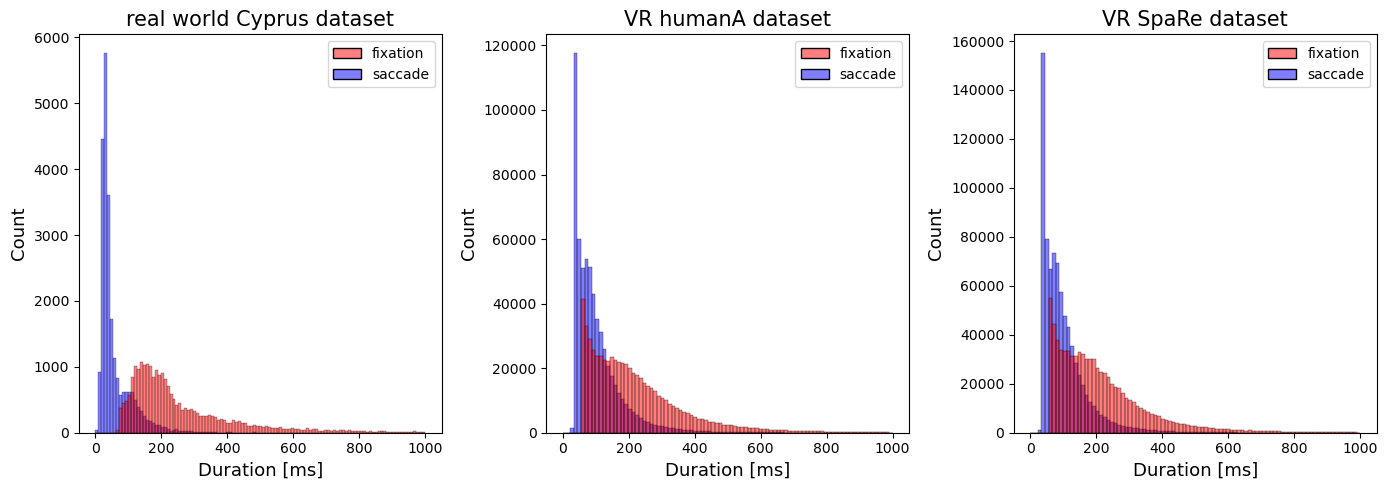

In [23]:
# filter the data sources to only plot everything below 1 sec of duration
bins = np.linspace(0, 1000, 112)  # 100 bins, 101 edges
binsHA = np.linspace(0, 1000, 92)  # 


# Make durations a DataFrame for consistent plotting
fix_df = pd.DataFrame({'duration_ms': fixationDurations, 'event': 'fixation'})
sac_df = pd.DataFrame({'duration_ms': saccadeDurations, 'event': 'saccade'})
comb_durs = pd.concat([fix_df, sac_df], ignore_index=True)

# Prefilter to match filtered_df's constraints (e.g., duration < 1000 ms)
comb_durs_filtered = comb_durs[comb_durs["duration_ms"] < 1000]



# cmap= cm.roma
# pal = cmap(np.linspace(0, 1, 2)).tolist()
# plt.rcParams['font.family'] = 'TeX Gyre Heros'
pal = {'fixation': 'red', 'saccade': 'blue'}



# Set up figure and axes
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=False)

# ---------- FIRST HISTPLOT ----------


# ---------- first plot - real world - Cyprus data

sns.histplot(
    data=comb_durs_filtered ,
    x="duration_ms",
    hue="event",
    bins=bins,
    kde=False,
    palette=pal,
    edgecolor = "black",
    ax=axes[0]
)

axes[0].set_xlabel("Duration [ms]", fontsize=13)
axes[0].set_ylabel("Count", fontsize=13)
axes[0].set_title("real world Cyprus dataset", fontsize=15)
axes[0].tick_params(axis='x')
axes[0].tick_params(axis='y')
if axes[0].get_legend() is not None:
    axes[0].get_legend().set_title(None)

# second plot - VR Data HA



sns.histplot(
    data=comb_durs_filteredHA ,
    x="duration_ms",
    hue="event",
    bins=binsHA,
    kde=False,
    palette=pal,
    edgecolor = "black",
    ax=axes[1]
)

axes[1].set_xlabel("Duration [ms]", fontsize=13)
axes[1].set_ylabel("Count", fontsize=13)
axes[1].set_title("VR humanA dataset", fontsize=15)
axes[1].tick_params(axis='x')
axes[1].tick_params(axis='y')
if axes[1].get_legend() is not None:
    axes[1].get_legend().set_title(None)


# third plot - VR data SR

sns.histplot(
    data=comb_durs_filteredSR ,
    x="duration_ms",
    hue="event",
    bins=binsHA,
    kde=False,
    palette=pal,
    edgecolor = "black",
    ax=axes[2]
)

axes[2].set_xlabel("Duration [ms]", fontsize=13)
axes[2].set_ylabel("Count", fontsize=13)
axes[2].set_title("VR SpaRe dataset", fontsize=15)
axes[2].tick_params(axis='x')
axes[2].tick_params(axis='y')
if axes[2].get_legend() is not None:
    axes[2].get_legend().set_title(None)



plt.tight_layout()

# Save the figure (adjust path if needed)
full_save_path = os.path.join(savepath, 'eyeMovement_durations_all3_2binsSizes.png')
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()

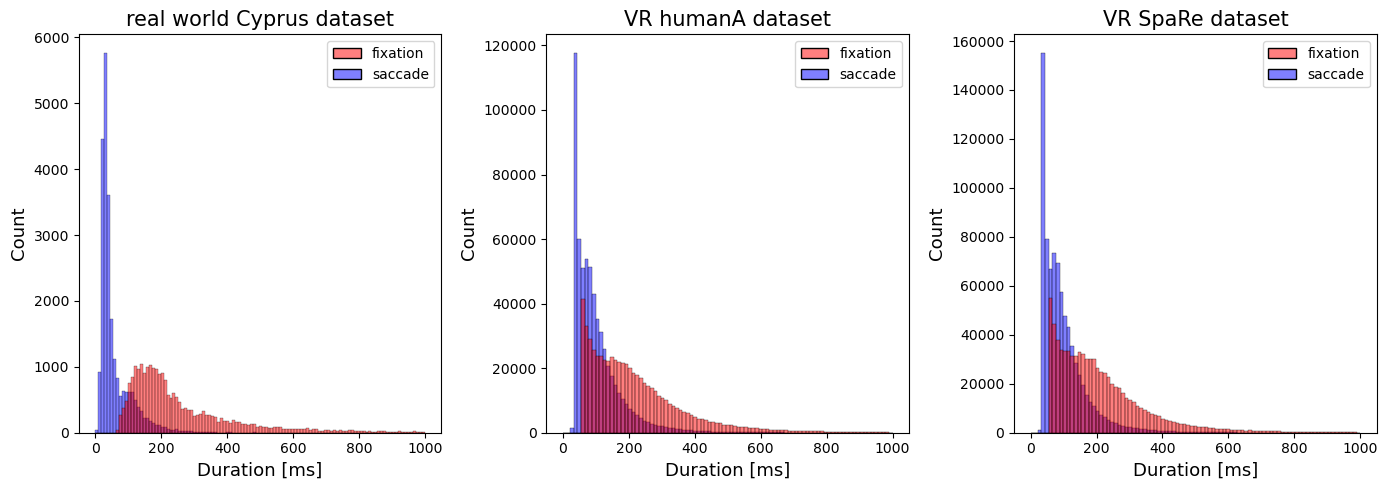

In [24]:
# filter the data sources to only plot everything below 1 sec of duration
# bins = np.linspace(0, 1000, 101)  # 100 bins, 101 edges
binsHA = np.linspace(0, 1000, 92)  # 
binwidth = 9


# Make durations a DataFrame for consistent plotting
fix_df = pd.DataFrame({'duration_ms': fixationDurations, 'event': 'fixation'})
sac_df = pd.DataFrame({'duration_ms': saccadeDurations, 'event': 'saccade'})
comb_durs = pd.concat([fix_df, sac_df], ignore_index=True)

# Prefilter to match filtered_df's constraints (e.g., duration < 1000 ms)
comb_durs_filtered = comb_durs[comb_durs["duration_ms"] < 1000]



# cmap= cm.roma
# pal = cmap(np.linspace(0, 1, 2)).tolist()
# plt.rcParams['font.family'] = 'TeX Gyre Heros'
pal = {'fixation': 'red', 'saccade': 'blue'}



# Set up figure and axes
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=False)

# ---------- FIRST HISTPLOT ----------


# ---------- first plot - real world - Cyprus data

sns.histplot(
    data=comb_durs_filtered ,
    x="duration_ms",
    hue="event",
    binwidth = binwidth,
    kde=False,
    palette=pal,
    ax=axes[0]
)

axes[0].set_xlabel("Duration [ms]", fontsize=13)
axes[0].set_ylabel("Count", fontsize=13)
axes[0].set_title("real world Cyprus dataset", fontsize=15)
axes[0].tick_params(axis='x')
axes[0].tick_params(axis='y')
if axes[0].get_legend() is not None:
    axes[0].get_legend().set_title(None)

# second plot - VR Data HA



sns.histplot(
    data=comb_durs_filteredHA ,
    x="duration_ms",
    hue="event",
    bins=binsHA,
    kde=False,
    palette=pal,
    ax=axes[1]
)

axes[1].set_xlabel("Duration [ms]", fontsize=13)
axes[1].set_ylabel("Count", fontsize=13)
axes[1].set_title("VR humanA dataset", fontsize=15)
axes[1].tick_params(axis='x')
axes[1].tick_params(axis='y')
if axes[1].get_legend() is not None:
    axes[1].get_legend().set_title(None)


# third plot - VR data SR

sns.histplot(
    data=comb_durs_filteredSR ,
    x="duration_ms",
    hue="event",
    bins=binsHA,
    kde=False,
    palette=pal,
    ax=axes[2]
)

axes[2].set_xlabel("Duration [ms]", fontsize=13)
axes[2].set_ylabel("Count", fontsize=13)
axes[2].set_title("VR SpaRe dataset", fontsize=15)
axes[2].tick_params(axis='x')
axes[2].tick_params(axis='y')
if axes[2].get_legend() is not None:
    axes[2].get_legend().set_title(None)



plt.tight_layout()

# Save the figure (adjust path if needed)
full_save_path = os.path.join(savepath, 'eyeMovement_durations_all3_binwidth.png')
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()

## plot VR means in histogram

In [25]:
# Prepare participant-wise arrays (dropna and < 1000 ms filter for each)
def get_valid_durations(lengths_df):
    return [col.dropna()[(col.dropna() * 1000) < 1000] * 1000 for _, col in lengths_df.items()]

In [26]:

n_bins = len(binsHA)-1
bin_centers = (binsHA[:-1] + binsHA[1:]) / 2

In [27]:
# Get lists of Series: one per participant
gaze_listsHA = get_valid_durations(gaze_lengthsHA)
sac_listsHA  = get_valid_durations(saccade_lengthsHA)


# Collect histograms: result shape will be (n_participants, n_bins)
fix_hist_participantsHA = np.array([np.histogram(d, bins=binsHA)[0] for d in gaze_listsHA])
sac_hist_participantsHA = np.array([np.histogram(d, bins=binsHA)[0] for d in sac_listsHA])

# Compute mean and std per bin (across participants)
fix_meansHA = fix_hist_participantsHA.mean(axis=0)
fix_stdsHA  = fix_hist_participantsHA.std(axis=0)
sac_meansHA = sac_hist_participantsHA.mean(axis=0)
sac_stdsHA  = sac_hist_participantsHA.std(axis=0)

In [28]:
# Get lists of Series: one per participant
gaze_listsSR = get_valid_durations(gaze_lengthsSR)
sac_listsSR  = get_valid_durations(saccade_lengthsSR)


# Collect histograms: result shape will be (n_participants, n_bins)
fix_hist_participantsSR = np.array([np.histogram(d, bins=binsHA)[0] for d in gaze_listsSR])
sac_hist_participantsSR = np.array([np.histogram(d, bins=binsHA)[0] for d in sac_listsSR])

# Compute mean and std per bin (across participants)
fix_meansSR = fix_hist_participantsSR.mean(axis=0)
fix_stdsSR= fix_hist_participantsSR.std(axis=0)
sac_meansSR = sac_hist_participantsSR.mean(axis=0)
sac_stdsSR  = sac_hist_participantsSR.std(axis=0)



### plot using seaborn and matplotlib

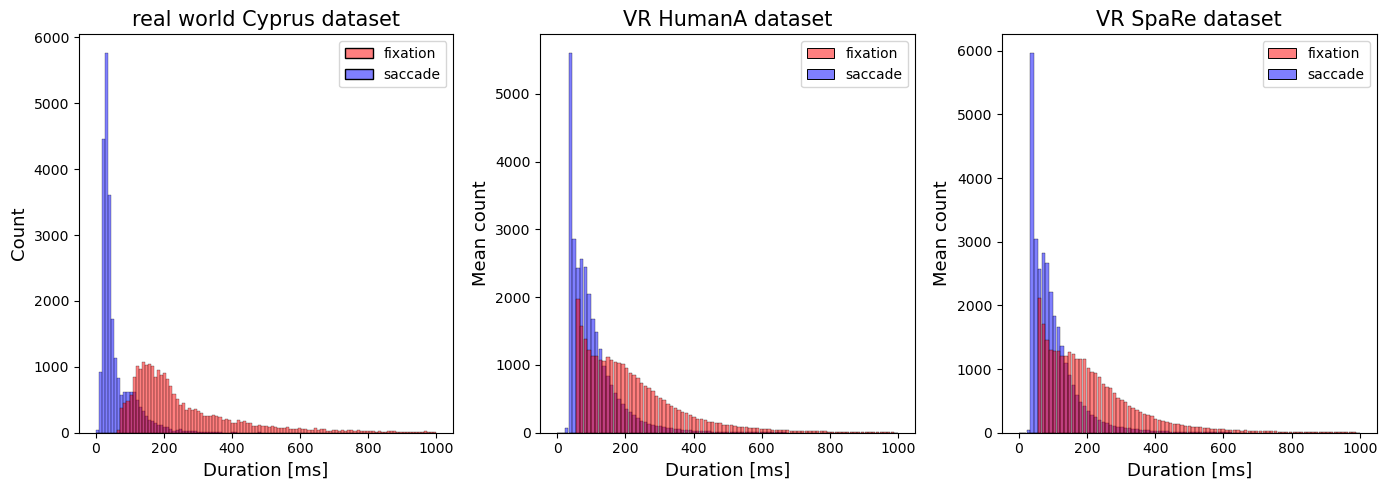

In [29]:
# filter the data sources to only plot everything below 1 sec of duration

bins = np.linspace(0, 1000, 112)  # 100 bins, 101 edges
binsHA = np.linspace(0, 1000, 92)  # 
# binwidth = 9


# Make durations a DataFrame for consistent plotting
fix_df = pd.DataFrame({'duration_ms': fixationDurations, 'event': 'fixation'})
sac_df = pd.DataFrame({'duration_ms': saccadeDurations, 'event': 'saccade'})
comb_durs = pd.concat([fix_df, sac_df], ignore_index=True)

# Prefilter to match filtered_df's constraints (e.g., duration < 1000 ms)
comb_durs_filtered = comb_durs[comb_durs["duration_ms"] < 1000]



# cmap= cm.roma
# pal = cmap(np.linspace(0, 1, 2)).tolist()
# plt.rcParams['font.family'] = 'TeX Gyre Heros'
pal = {'fixation': 'red', 'saccade': 'blue'}



# Set up figure and axes
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=False)

# ---------- FIRST HISTPLOT ----------


# ---------- first plot - real world - Cyprus data

sns.histplot(
    data=comb_durs_filtered ,
    x="duration_ms",
    hue="event",
    bins = bins,
    kde=False,
    palette=pal,
    edgecolor = "black",
    ax=axes[0]
)

axes[0].set_xlabel("Duration [ms]", fontsize=13)
axes[0].set_ylabel("Count", fontsize=13)
axes[0].set_title("real world Cyprus dataset", fontsize=15)
axes[0].tick_params(axis='x')
axes[0].tick_params(axis='y')
if axes[0].get_legend() is not None:
    axes[0].get_legend().set_title(None)

# second plot - VR Data HA


# sns.barplot(
#     x=bin_centers,
#     y=sac_means,
#     color=(0.0, 0.0, 1.0, 0.5),
#     alpha=0.5,
#     linewidth=0.21,
#     edgecolor='black',     # edgecolor as RGBA isn't accepted directly, use 'white'
#     width=1.1,            # Or matching your bin width!
#     ax=axes[1]
# )
# sns.barplot(
#     x=bin_centers,
#     y=fix_means,
#     color= (1.0, 0.0, 0.0, 0.5),
#     alpha = 1,
#     linewidth=0.21,
#     edgecolor='black',     # edgecolor as RGBA isn't accepted directly, use 'white'
#     width=1.1,            # Or matching your bin width!
#     ax=axes[1]
# )

ax = axes[1]  # same as axes[1] in your layout

ax.bar(
    bin_centers,
    sac_meansHA,
    width = 10.1,
    color=(0, 0, 1, 0.5),        # RGBA: blue at 0.5 alpha
    edgecolor='black',
    linewidth=0.22,
    label='saccade'
)

# Plot red (fixation) bars OVER blue for correct stacking
ax.bar(
    bin_centers,
    fix_meansHA,
    width = 10.1,
    color=(1, 0, 0, 0.5),        # RGBA: red at 0.5 alpha
    edgecolor='black',
    linewidth=0.22,
    label='fixation'
)

handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles[::-1], labels[::-1], title=None)

# Set the edge color for the legend patches
for patch in leg.get_patches():
    patch.set_edgecolor('black')
    patch.set_linewidth(0.7)


axes[1].set_xlabel('Duration [ms]', fontsize=13)
axes[1].set_ylabel('Mean count', fontsize=13)
axes[1].set_title('VR HumanA dataset', fontsize=15)

# axes[1].tick_params(axis='x')
# axes[1].tick_params(axis='y')
# axes[1].set_xticklabels([])
# if axes[1].get_legend() is not None:
#     axes[1].get_legend().set_title(None)
# tick_positions = [0, 18, 36, 54, 72, 91]
# tick_labels = ['0', '200', '400', '600', '800', '1000']
# axes[1].set_xticks(tick_positions)
# axes[1].set_xticklabels(tick_labels)

# Add a y-axis grid
# axes[1].grid(axis='y', color='gray', linestyle='--', linewidth=0.7, zorder=0)



# sns.histplot(
#     data=comb_durs_filteredHA ,
#     x="duration_ms",
#     hue="event",
#     bins=binsHA,
#     kde=False,
#     palette=pal,
#     ax=axes[1]
# )

# axes[1].set_xlabel("Duration [ms]", fontsize=13)
# axes[1].set_ylabel("Count", fontsize=13)
# axes[1].set_title("VR humanA dataset", fontsize=15)
# axes[1].tick_params(axis='x')
# axes[1].tick_params(axis='y')



# third plot - VR data SR

ax = axes[2]  # same as axes[1] in your layout

ax.bar(
    bin_centers,
    sac_meansSR,
    width = 10.1,
    color=(0, 0, 1, 0.5),        # RGBA: blue at 0.5 alpha
    edgecolor='black',
    linewidth=0.22,
    label='saccade'
)

# Plot red (fixation) bars OVER blue for correct stacking
ax.bar(
    bin_centers,
    fix_meansSR,
    width = 10.1,
    color=(1, 0, 0, 0.5),        # RGBA: red at 0.5 alpha
    edgecolor='black',
    linewidth=0.22,
    label='fixation'
)

handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles[::-1], labels[::-1], title=None)

# Set the edge color for the legend patches
for patch in leg.get_patches():
    patch.set_edgecolor('black')
    patch.set_linewidth(0.7)
    
    
axes[2].set_xlabel('Duration [ms]', fontsize=13)
axes[2].set_ylabel('Mean count', fontsize=13)
axes[2].set_title('VR SpaRe dataset',  fontsize=15)




# sns.histplot(
#     data=comb_durs_filteredSR ,
#     x="duration_ms",
#     hue="event",
#     bins=binsHA,
#     kde=False,
#     palette=pal,
#     edgecolor = "black",
#     ax=axes[2]
# )

# axes[2].set_xlabel("Duration [ms]", fontsize=13)
# axes[2].set_ylabel("Count", fontsize=13)
# axes[2].set_title("VR SpaRe dataset", fontsize=15)
# axes[2].tick_params(axis='x')
# axes[2].tick_params(axis='y')
# if axes[2].get_legend() is not None:
#     axes[2].get_legend().set_title(None)




plt.tight_layout()

# Save the figure (adjust path if needed)
full_save_path = os.path.join(savepath, 'eyeMovement_durations_VRmeans_snsPLt.png')
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()


# # Examine the first subplot (axes[0])
# print('Number of bars in axes[0]:', len(axes[0].patches))
# for i, patch in enumerate(axes[0].patches[100:103]):  # print for the first 3 bars
#     print(f'Bar {i}:')
#     print('  alpha:', patch.get_alpha())
#     print('  linewidth:', patch.get_linewidth())
#     try:
#         print('  width:', patch.get_width())
#     except AttributeError:
#         print('  No width (not a Rectangle)')
#     print('  edgecolor:', patch.get_edgecolor())
#     print('  facecolor:', patch.get_facecolor())


# # Examine the first subplot (axes[0])
# print('Number of bars in axes[1]:', len(axes[1].patches))
# for i, patch in enumerate(axes[1].patches[100:103]):  # print for the first 3 bars
#     print(f'Bar {i}:')
#     print('  alpha:', patch.get_alpha())
#     print('  linewidth:', patch.get_linewidth())
#     try:
#         print('  width:', patch.get_width())
#     except AttributeError:
#         print('  No width (not a Rectangle)')
#     print('  edgecolor:', patch.get_edgecolor())
#     print('  facecolor:', patch.get_facecolor())
#     x0 = patch.get_x()
    

In [30]:
# bins = np.linspace(0, 1000, 100)  # 100 bins, 101 edges
# binsHA = np.linspace(0, 1000, 92)  # 
# binwidth = 9
# print(binsHA[:5])
# print(bins[:5])
# binsBW = np.linspace(0, 1000, 112) 
# print(binsBW[:5])

### plot using only matptlotlib

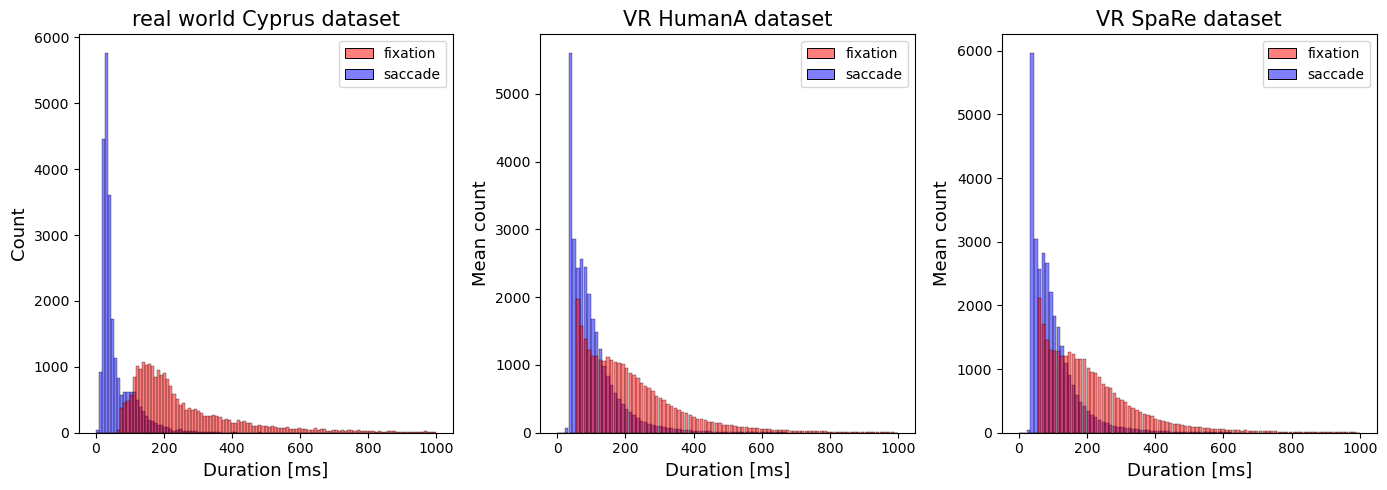

In [31]:
# filter the data sources to only plot everything below 1 sec of duration

bins = np.linspace(0, 1000, 112)   # roughly matching binwidth = 9
binsHA = np.linspace(0, 1000, 92)  # 



# # Make durations a DataFrame for consistent plotting
# fix_df = pd.DataFrame({'duration_ms': fixationDurations, 'event': 'fixation'})
# sac_df = pd.DataFrame({'duration_ms': saccadeDurations, 'event': 'saccade'})
# comb_durs = pd.concat([fix_df, sac_df], ignore_index=True)

# # Prefilter to match filtered_df's constraints (e.g., duration < 1000 ms)
# comb_durs_filtered = comb_durs[comb_durs["duration_ms"] < 1000]

# Filtered data for each event (convert to numpy array if needed)
fix_durs = np.array(fixationDurations)[np.array(fixationDurations) < 1000]
sac_durs = np.array(saccadeDurations)[np.array(saccadeDurations) < 1000]


# cmap= cm.roma
# pal = cmap(np.linspace(0, 1, 2)).tolist()
# plt.rcParams['font.family'] = 'TeX Gyre Heros'
pal = {'fixation': 'red', 'saccade': 'blue'}



# Set up figure and axes
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=False)

# ---------- FIRST HISTPLOT ----------


# ---------- first plot - real world - Cyprus data

ax = axes[0]


# Plot "fixation" histogram (red, semi-transparent)

# Plot "saccade" histogram (blue, semi-transparent)
ax.hist(
    sac_durs,
    bins = bins,
    color=(0,0,1,0.5),          # RGBA: blue, 0.5 alpha
    edgecolor="black",
    linewidth=0.22,
    label="saccade"
)
ax.hist(
    fix_durs,
    bins = bins,
    color=(1,0,0,0.5),          # RGBA: red, 0.5 alpha
    edgecolor="black",
    linewidth=0.22,
    label="fixation"
)

# Axis labels and formatting
ax.set_xlabel("Duration [ms]", fontsize=13)
ax.set_ylabel("Count", fontsize=13)
ax.set_title("real world Cyprus dataset", fontsize=15)
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# # Legend: Ensure correct order (fixation on top, saccade below, to match others)
handles, labels_ = ax.get_legend_handles_labels()
leg = ax.legend(handles[::-1], labels_[::-1], title=None)
for patch in leg.get_patches():
    patch.set_edgecolor('black')
    patch.set_linewidth(0.7)

    

# sns.histplot(
#     data=comb_durs_filtered ,
#     x="duration_ms",
#     hue="event",
#     bins=bins,
#     kde=False,
#     palette=pal,
#     edgecolor = "black",
#     ax=axes[0]
# )

# axes[0].set_xlabel("Duration [ms] (inkl. blinks)", fontsize=13)
# axes[0].set_ylabel("Count", fontsize=13)
# axes[0].set_title("real world - Cyprus data", fontsize=15)
# axes[0].tick_params(axis='x')
# axes[0].tick_params(axis='y')
# if axes[0].get_legend() is not None:
#     axes[0].get_legend().set_title(None)

# second plot - VR Data HA


# sns.barplot(
#     x=bin_centers,
#     y=sac_means,
#     color=(0.0, 0.0, 1.0, 0.5),
#     alpha=0.5,
#     linewidth=0.21,
#     edgecolor='black',     # edgecolor as RGBA isn't accepted directly, use 'white'
#     width=1.1,            # Or matching your bin width!
#     ax=axes[1]
# )
# sns.barplot(
#     x=bin_centers,
#     y=fix_means,
#     color= (1.0, 0.0, 0.0, 0.5),
#     alpha = 1,
#     linewidth=0.21,
#     edgecolor='black',     # edgecolor as RGBA isn't accepted directly, use 'white'
#     width=1.1,            # Or matching your bin width!
#     ax=axes[1]
# )

ax = axes[1]  # same as axes[1] in your layout

ax.bar(
    bin_centers,
    sac_meansHA,
    width = 10.1,
    color=(0, 0, 1, 0.5),        # RGBA: blue at 0.5 alpha
    edgecolor='black',
    linewidth=0.22,
    label='saccade'
)

# Plot red (fixation) bars OVER blue for correct stacking
ax.bar(
    bin_centers,
    fix_meansHA,
    width = 10.1,
    color=(1, 0, 0, 0.5),        # RGBA: red at 0.5 alpha
    edgecolor='black',
    linewidth=0.22,
    label='fixation'
)

handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles[::-1], labels[::-1], title=None)

# Set the edge color for the legend patches
for patch in leg.get_patches():
    patch.set_edgecolor('black')
    patch.set_linewidth(0.7)


axes[1].set_xlabel('Duration [ms]',fontsize=13)
axes[1].set_ylabel('Mean count',fontsize=13)
axes[1].set_title('VR HumanA dataset',fontsize=15)

# axes[1].tick_params(axis='x')
# axes[1].tick_params(axis='y')
# axes[1].set_xticklabels([])
# if axes[1].get_legend() is not None:
#     axes[1].get_legend().set_title(None)
# tick_positions = [0, 18, 36, 54, 72, 91]
# tick_labels = ['0', '200', '400', '600', '800', '1000']
# axes[1].set_xticks(tick_positions)
# axes[1].set_xticklabels(tick_labels)

# Add a y-axis grid
# axes[1].grid(axis='y', color='gray', linestyle='--', linewidth=0.7, zorder=0)



# sns.histplot(
#     data=comb_durs_filteredHA ,
#     x="duration_ms",
#     hue="event",
#     bins=binsHA,
#     kde=False,
#     palette=pal,
#     ax=axes[1]
# )

# axes[1].set_xlabel("Duration [ms]", fontsize=13)
# axes[1].set_ylabel("Count", fontsize=13)
# axes[1].set_title("VR humanA dataset", fontsize=15)
# axes[1].tick_params(axis='x')
# axes[1].tick_params(axis='y')



# third plot - VR data SR

ax = axes[2]  # same as axes[1] in your layout

ax.bar(
    bin_centers,
    sac_meansSR,
    width = 10.1,
    color=(0, 0, 1, 0.5),        # RGBA: blue at 0.5 alpha
    edgecolor='black',
    linewidth=0.22,
    label='saccade'
)

# Plot red (fixation) bars OVER blue for correct stacking
ax.bar(
    bin_centers,
    fix_meansSR,
    width = 10.1,
    color=(1, 0, 0, 0.5),        # RGBA: red at 0.5 alpha
    edgecolor='black',
    linewidth=0.22,
    label='fixation'
)

handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles[::-1], labels[::-1], title=None)

# Set the edge color for the legend patches
for patch in leg.get_patches():
    patch.set_edgecolor('black')
    patch.set_linewidth(0.7)
    
    
axes[2].set_xlabel('Duration [ms]',fontsize=13)
axes[2].set_ylabel('Mean count',fontsize=13)
axes[2].set_title('VR SpaRe dataset',fontsize=15)




# sns.histplot(
#     data=comb_durs_filteredSR ,
#     x="duration_ms",
#     hue="event",
#     bins=binsHA,
#     kde=False,
#     palette=pal,
#     edgecolor = "black",
#     ax=axes[2]
# )

# axes[2].set_xlabel("Duration [ms]", fontsize=13)
# axes[2].set_ylabel("Count", fontsize=13)
# axes[2].set_title("VR SpaRe dataset", fontsize=15)
# axes[2].tick_params(axis='x')
# axes[2].tick_params(axis='y')
# if axes[2].get_legend() is not None:
#     axes[2].get_legend().set_title(None)




plt.tight_layout()

# Save the figure (adjust path if needed)
full_save_path = os.path.join(savepath, 'eyeMovement_durations_VRmeans_pltOnly.png')
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()

    

### now plot while adding the shaded std bars

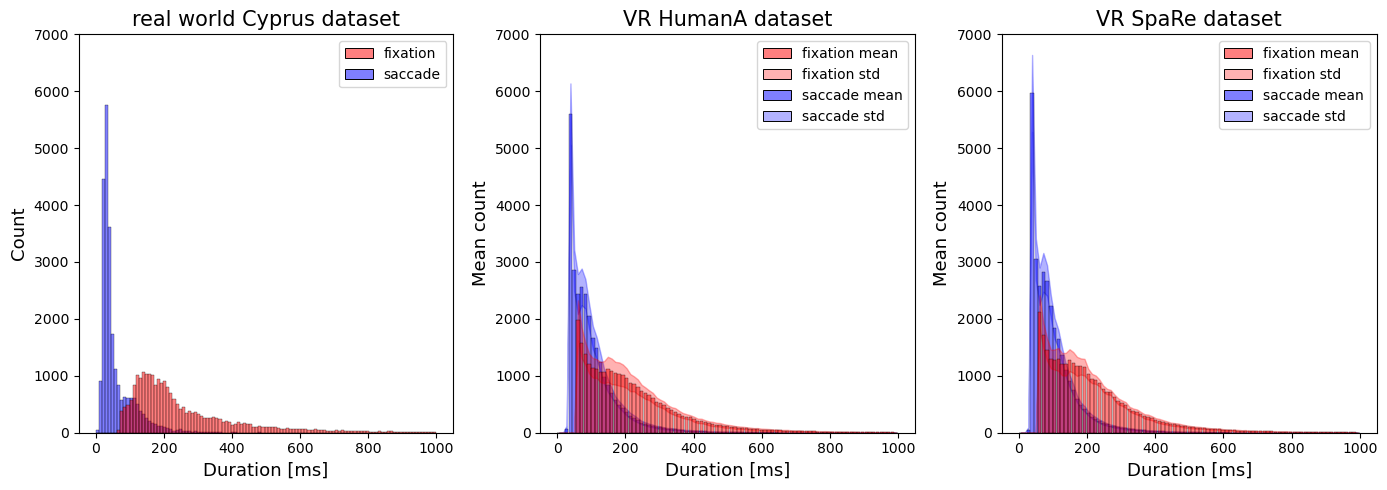

In [32]:
# filter the data sources to only plot everything below 1 sec of duration

bins = np.linspace(0, 1000, 112)   # roughly matching binwidth = 9
binsHA = np.linspace(0, 1000, 92)  # 



# # Make durations a DataFrame for consistent plotting
# fix_df = pd.DataFrame({'duration_ms': fixationDurations, 'event': 'fixation'})
# sac_df = pd.DataFrame({'duration_ms': saccadeDurations, 'event': 'saccade'})
# comb_durs = pd.concat([fix_df, sac_df], ignore_index=True)

# # Prefilter to match filtered_df's constraints (e.g., duration < 1000 ms)
# comb_durs_filtered = comb_durs[comb_durs["duration_ms"] < 1000]

# Filtered data for each event (convert to numpy array if needed)
fix_durs = np.array(fixationDurations)[np.array(fixationDurations) < 1000]
sac_durs = np.array(saccadeDurations)[np.array(saccadeDurations) < 1000]


# cmap= cm.roma
# pal = cmap(np.linspace(0, 1, 2)).tolist()
# plt.rcParams['font.family'] = 'TeX Gyre Heros'
pal = {'fixation': 'red', 'saccade': 'blue'}



# Set up figure and axes
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=False)

# ---------- FIRST HISTPLOT ----------


# ---------- first plot - real world - Cyprus data

ax = axes[0]


# Plot "fixation" histogram (red, semi-transparent)

# Plot "saccade" histogram (blue, semi-transparent)
ax.hist(
    sac_durs,
    bins = bins,
    color=(0,0,1,0.5),          # RGBA: blue, 0.5 alpha
    edgecolor="black",
    linewidth=0.22,
    label="saccade"
)
ax.hist(
    fix_durs,
    bins = bins,
    color=(1,0,0,0.5),          # RGBA: red, 0.5 alpha
    edgecolor="black",
    linewidth=0.22,
    label="fixation"
)

# Axis labels and formatting
ax.set_xlabel("Duration [ms]", fontsize=13)
ax.set_ylabel("Count", fontsize=13)
ax.set_title("real world Cyprus dataset", fontsize=15)
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# # Legend: Ensure correct order (fixation on top, saccade below, to match others)
handles, labels_ = ax.get_legend_handles_labels()
leg = ax.legend(handles[::-1], labels_[::-1], title=None)
for patch in leg.get_patches():
    patch.set_edgecolor('black')
    patch.set_linewidth(0.7)

    

# sns.histplot(
#     data=comb_durs_filtered ,
#     x="duration_ms",
#     hue="event",
#     bins=bins,
#     kde=False,
#     palette=pal,
#     edgecolor = "black",
#     ax=axes[0]
# )

# axes[0].set_xlabel("Duration [ms] (inkl. blinks)", fontsize=13)
# axes[0].set_ylabel("Count", fontsize=13)
# axes[0].set_title("real world - Cyprus data", fontsize=15)
# axes[0].tick_params(axis='x')
# axes[0].tick_params(axis='y')
# if axes[0].get_legend() is not None:
#     axes[0].get_legend().set_title(None)

# second plot - VR Data HA


# sns.barplot(
#     x=bin_centers,
#     y=sac_means,
#     color=(0.0, 0.0, 1.0, 0.5),
#     alpha=0.5,
#     linewidth=0.21,
#     edgecolor='black',     # edgecolor as RGBA isn't accepted directly, use 'white'
#     width=1.1,            # Or matching your bin width!
#     ax=axes[1]
# )
# sns.barplot(
#     x=bin_centers,
#     y=fix_means,
#     color= (1.0, 0.0, 0.0, 0.5),
#     alpha = 1,
#     linewidth=0.21,
#     edgecolor='black',     # edgecolor as RGBA isn't accepted directly, use 'white'
#     width=1.1,            # Or matching your bin width!
#     ax=axes[1]
# )

ax = axes[1]  # same as axes[1] in your layout

ax.fill_between(bin_centers, sac_meansHA-sac_stdsHA, sac_meansHA+sac_stdsHA, color=(0, 0, 1, 0.3), alpha=0.3, label='saccade std')

ax.bar(
    bin_centers,
    sac_meansHA,
    width = 10.1,
    color=(0, 0, 1, 0.5),        # RGBA: blue at 0.5 alpha
    edgecolor='black',
    linewidth=0.22,
    label='saccade mean'
)

# Plot red (fixation) bars OVER blue for correct stacking
ax.fill_between(bin_centers, fix_meansHA-fix_stdsHA, fix_meansHA+fix_stdsHA, color=(1, 0, 0, 0.3), alpha=0.3, label='fixation std')

ax.bar(
    bin_centers,
    fix_meansHA,
    width = 10.1,
    color=(1, 0, 0, 0.5),        # RGBA: red at 0.5 alpha
    edgecolor='black',
    linewidth=0.22,
    label='fixation mean'
)

desired_order = ['fixation mean', 'fixation std', 'saccade mean', 'saccade std']
handles, labels = ax.get_legend_handles_labels()
handle_dict = dict(zip(labels, handles))
ordered_handles = [handle_dict[lab] for lab in desired_order if lab in handle_dict]
ordered_labels = [lab for lab in desired_order if lab in handle_dict]
leg = ax.legend(ordered_handles, ordered_labels, title=None)
for patch in leg.get_patches():
    patch.set_edgecolor('black')
    patch.set_linewidth(0.7)

axes[1].set_xlabel('Duration [ms]',fontsize=13)
axes[1].set_ylabel('Mean count',fontsize=13)
axes[1].set_title('VR HumanA dataset',fontsize=15)

# axes[1].tick_params(axis='x')
# axes[1].tick_params(axis='y')
# axes[1].set_xticklabels([])
# if axes[1].get_legend() is not None:
#     axes[1].get_legend().set_title(None)
# tick_positions = [0, 18, 36, 54, 72, 91]
# tick_labels = ['0', '200', '400', '600', '800', '1000']
# axes[1].set_xticks(tick_positions)
# axes[1].set_xticklabels(tick_labels)

# Add a y-axis grid
# axes[1].grid(axis='y', color='gray', linestyle='--', linewidth=0.7, zorder=0)



# sns.histplot(
#     data=comb_durs_filteredHA ,
#     x="duration_ms",
#     hue="event",
#     bins=binsHA,
#     kde=False,
#     palette=pal,
#     ax=axes[1]
# )

# axes[1].set_xlabel("Duration [ms]", fontsize=13)
# axes[1].set_ylabel("Count", fontsize=13)
# axes[1].set_title("VR humanA dataset", fontsize=15)
# axes[1].tick_params(axis='x')
# axes[1].tick_params(axis='y')



# third plot - VR data SR

ax = axes[2]  # same as axes[1] in your layout

# Saccade: mean+std
ax.fill_between(bin_centers, sac_meansSR-sac_stdsSR, sac_meansSR+sac_stdsSR, color=(0, 0, 1, 0.3), alpha=0.3, label='saccade std')

ax.bar(
    bin_centers,
    sac_meansSR,
    width = 10.1,
    color=(0, 0, 1, 0.5),        # RGBA: blue at 0.5 alpha
    edgecolor='black',
    linewidth=0.22,
    label='saccade mean'
)

# Plot red (fixation) bars OVER blue for correct stacking

# Fixation: mean+std
ax.fill_between(bin_centers, fix_meansSR-fix_stdsSR, fix_meansSR+fix_stdsSR, color=(1, 0, 0, 0.3), alpha=0.3, label='fixation std')

ax.bar(
    bin_centers,
    fix_meansSR,
    width = 10.1,
    color=(1, 0, 0, 0.5),        # RGBA: red at 0.5 alpha
    edgecolor='black',
    linewidth=0.22,
    label='fixation mean'
)

desired_order = ['fixation mean', 'fixation std', 'saccade mean', 'saccade std']
handles, labels = ax.get_legend_handles_labels()
handle_dict = dict(zip(labels, handles))
ordered_handles = [handle_dict[lab] for lab in desired_order if lab in handle_dict]
ordered_labels = [lab for lab in desired_order if lab in handle_dict]
leg = ax.legend(ordered_handles, ordered_labels, title=None)
for patch in leg.get_patches():
    patch.set_edgecolor('black')
    patch.set_linewidth(0.7)
    
    
axes[2].set_xlabel('Duration [ms]',fontsize=13)
axes[2].set_ylabel('Mean count',fontsize=13)
axes[2].set_title('VR SpaRe dataset',fontsize=15)




# sns.histplot(
#     data=comb_durs_filteredSR ,
#     x="duration_ms",
#     hue="event",
#     bins=binsHA,
#     kde=False,
#     palette=pal,
#     edgecolor = "black",
#     ax=axes[2]
# )

# axes[2].set_xlabel("Duration [ms]", fontsize=13)
# axes[2].set_ylabel("Count", fontsize=13)
# axes[2].set_title("VR SpaRe dataset", fontsize=15)
# axes[2].tick_params(axis='x')
# axes[2].tick_params(axis='y')
# if axes[2].get_legend() is not None:
#     axes[2].get_legend().set_title(None)


for ax in axes:
    ax.set_ylim(0, 7000)

plt.tight_layout()

# Save the figure (adjust path if needed)
full_save_path = os.path.join(savepath, 'eyeMovement_durations_VRmeans_std.png')
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()

    

In [33]:
print(fix_meansHA[:10])
print(fix_meansSR[:10])

[   0.            0.            0.            0.            2.23809524
 1973.33333333 1576.95238095 1386.61904762 1213.38095238 1138.76190476]
[   0.            0.            0.            0.            2.15384615
 2121.11538462 1711.76923077 1460.11538462 1296.26923077 1286.15384615]


## eye movement distribution but real world plot uses only data with blink samples excluded

In [34]:
big_df["duration_ms"] = big_df["duration_ns"]/ 1e6
filtered_df = big_df[big_df["duration_ms"] < 1000] 
filtered_df.tail()

,event_id,first,last,duration_ns,duration_ms,event,session
46181,3269.0,1694102629510933419,1694102629535846419,24913000,24.913,saccade,Expl_5_ET_2_2023-09-07_18-48-26_ET
46182,2416.0,1694102629542222419,1694102629835884419,293662000,293.662,fixation,Expl_5_ET_2_2023-09-07_18-48-26_ET
46183,3271.0,1694102629842147419,1694102629876483419,34336000,34.336,saccade,Expl_5_ET_2_2023-09-07_18-48-26_ET
46184,2417.0,1694102629882958419,1694102630114006419,231048000,231.048,fixation,Expl_5_ET_2_2023-09-07_18-48-26_ET
46185,3273.0,1694102630117459419,1694102630151579419,34120000,34.120,saccade,Expl_5_ET_2_2023-09-07_18-48-26_ET


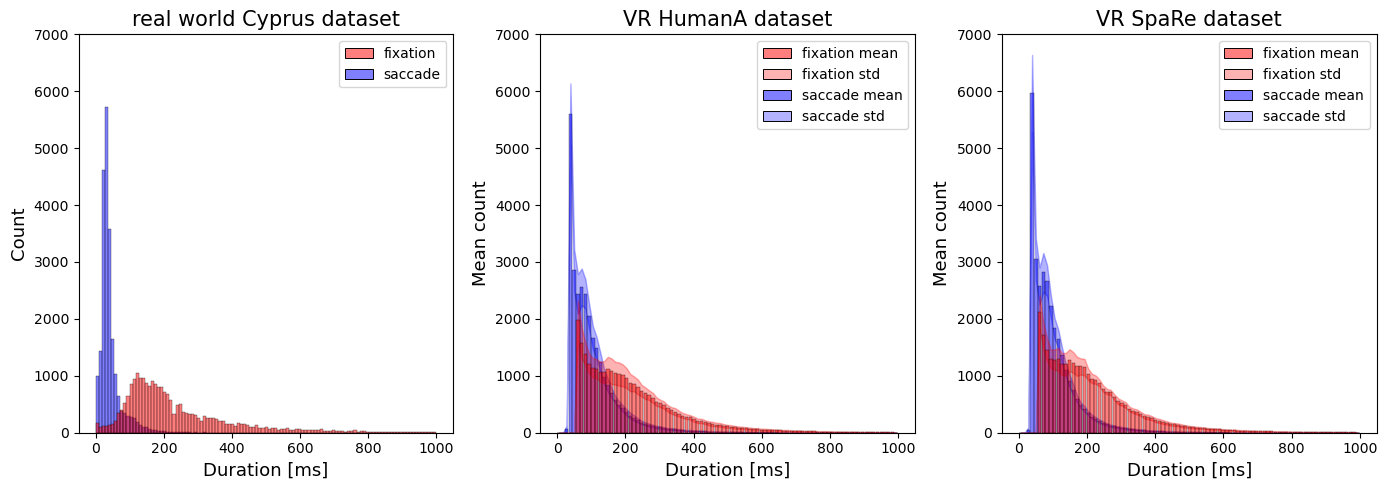

In [35]:
# filter the data sources to only plot everything below 1 sec of duration

bins = np.linspace(0, 1000, 112)   # roughly matching binwidth = 9
binsHA = np.linspace(0, 1000, 92)  # 



# # Make durations a DataFrame for consistent plotting
# fix_df = pd.DataFrame({'duration_ms': fixationDurations, 'event': 'fixation'})
# sac_df = pd.DataFrame({'duration_ms': saccadeDurations, 'event': 'saccade'})
# comb_durs = pd.concat([fix_df, sac_df], ignore_index=True)

# # Prefilter to match filtered_df's constraints (e.g., duration < 1000 ms)
# comb_durs_filtered = comb_durs[comb_durs["duration_ms"] < 1000]

fix_durs = filtered_df.loc[filtered_df['event'] == 'fixation',
                           'duration_ms']
sac_durs = filtered_df.loc[filtered_df['event'] == 'saccade',
                           'duration_ms']



# cmap= cm.roma
# pal = cmap(np.linspace(0, 1, 2)).tolist()
# plt.rcParams['font.family'] = 'TeX Gyre Heros'
pal = {'fixation': 'red', 'saccade': 'blue'}



# Set up figure and axes
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=False)

# ---------- FIRST HISTPLOT ----------


# ---------- first plot - real world - Cyprus data

ax = axes[0]


# Plot "fixation" histogram (red, semi-transparent)

# Plot "saccade" histogram (blue, semi-transparent)
ax.hist(
    sac_durs,
    bins = bins,
    color=(0,0,1,0.5),          # RGBA: blue, 0.5 alpha
    edgecolor="black",
    linewidth=0.22,
    label="saccade"
)
ax.hist(
    fix_durs,
    bins = bins,
    color=(1,0,0,0.5),          # RGBA: red, 0.5 alpha
    edgecolor="black",
    linewidth=0.22,
    label="fixation"
)

# Axis labels and formatting
ax.set_xlabel("Duration [ms]", fontsize=13)
ax.set_ylabel("Count", fontsize=13)
ax.set_title("real world Cyprus dataset", fontsize=15)
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# # Legend: Ensure correct order (fixation on top, saccade below, to match others)
handles, labels_ = ax.get_legend_handles_labels()
leg = ax.legend(handles[::-1], labels_[::-1], title=None)
for patch in leg.get_patches():
    patch.set_edgecolor('black')
    patch.set_linewidth(0.7)

    

# sns.histplot(
#     data=comb_durs_filtered ,
#     x="duration_ms",
#     hue="event",
#     bins=bins,
#     kde=False,
#     palette=pal,
#     edgecolor = "black",
#     ax=axes[0]
# )

# axes[0].set_xlabel("Duration [ms] (inkl. blinks)", fontsize=13)
# axes[0].set_ylabel("Count", fontsize=13)
# axes[0].set_title("real world - Cyprus data", fontsize=15)
# axes[0].tick_params(axis='x')
# axes[0].tick_params(axis='y')
# if axes[0].get_legend() is not None:
#     axes[0].get_legend().set_title(None)

# second plot - VR Data HA


# sns.barplot(
#     x=bin_centers,
#     y=sac_means,
#     color=(0.0, 0.0, 1.0, 0.5),
#     alpha=0.5,
#     linewidth=0.21,
#     edgecolor='black',     # edgecolor as RGBA isn't accepted directly, use 'white'
#     width=1.1,            # Or matching your bin width!
#     ax=axes[1]
# )
# sns.barplot(
#     x=bin_centers,
#     y=fix_means,
#     color= (1.0, 0.0, 0.0, 0.5),
#     alpha = 1,
#     linewidth=0.21,
#     edgecolor='black',     # edgecolor as RGBA isn't accepted directly, use 'white'
#     width=1.1,            # Or matching your bin width!
#     ax=axes[1]
# )

ax = axes[1]  # same as axes[1] in your layout

ax.fill_between(bin_centers, sac_meansHA-sac_stdsHA, sac_meansHA+sac_stdsHA, color=(0, 0, 1, 0.3), alpha=0.3, label='saccade std')

ax.bar(
    bin_centers,
    sac_meansHA,
    width = 10.1,
    color=(0, 0, 1, 0.5),        # RGBA: blue at 0.5 alpha
    edgecolor='black',
    linewidth=0.22,
    label='saccade mean'
)

# Plot red (fixation) bars OVER blue for correct stacking
ax.fill_between(bin_centers, fix_meansHA-fix_stdsHA, fix_meansHA+fix_stdsHA, color=(1, 0, 0, 0.3), alpha=0.3, label='fixation std')

ax.bar(
    bin_centers,
    fix_meansHA,
    width = 10.1,
    color=(1, 0, 0, 0.5),        # RGBA: red at 0.5 alpha
    edgecolor='black',
    linewidth=0.22,
    label='fixation mean'
)

desired_order = ['fixation mean', 'fixation std', 'saccade mean', 'saccade std']
handles, labels = ax.get_legend_handles_labels()
handle_dict = dict(zip(labels, handles))
ordered_handles = [handle_dict[lab] for lab in desired_order if lab in handle_dict]
ordered_labels = [lab for lab in desired_order if lab in handle_dict]
leg = ax.legend(ordered_handles, ordered_labels, title=None)
for patch in leg.get_patches():
    patch.set_edgecolor('black')
    patch.set_linewidth(0.7)

axes[1].set_xlabel('Duration [ms]',fontsize=13)
axes[1].set_ylabel('Mean count',fontsize=13)
axes[1].set_title('VR HumanA dataset',fontsize=15)

# axes[1].tick_params(axis='x')
# axes[1].tick_params(axis='y')
# axes[1].set_xticklabels([])
# if axes[1].get_legend() is not None:
#     axes[1].get_legend().set_title(None)
# tick_positions = [0, 18, 36, 54, 72, 91]
# tick_labels = ['0', '200', '400', '600', '800', '1000']
# axes[1].set_xticks(tick_positions)
# axes[1].set_xticklabels(tick_labels)

# Add a y-axis grid
# axes[1].grid(axis='y', color='gray', linestyle='--', linewidth=0.7, zorder=0)



# sns.histplot(
#     data=comb_durs_filteredHA ,
#     x="duration_ms",
#     hue="event",
#     bins=binsHA,
#     kde=False,
#     palette=pal,
#     ax=axes[1]
# )

# axes[1].set_xlabel("Duration [ms]", fontsize=13)
# axes[1].set_ylabel("Count", fontsize=13)
# axes[1].set_title("VR humanA dataset", fontsize=15)
# axes[1].tick_params(axis='x')
# axes[1].tick_params(axis='y')



# third plot - VR data SR

ax = axes[2]  # same as axes[1] in your layout

# Saccade: mean+std
ax.fill_between(bin_centers, sac_meansSR-sac_stdsSR, sac_meansSR+sac_stdsSR, color=(0, 0, 1, 0.3), alpha=0.3, label='saccade std')

ax.bar(
    bin_centers,
    sac_meansSR,
    width = 10.1,
    color=(0, 0, 1, 0.5),        # RGBA: blue at 0.5 alpha
    edgecolor='black',
    linewidth=0.22,
    label='saccade mean'
)

# Plot red (fixation) bars OVER blue for correct stacking

# Fixation: mean+std
ax.fill_between(bin_centers, fix_meansSR-fix_stdsSR, fix_meansSR+fix_stdsSR, color=(1, 0, 0, 0.3), alpha=0.3, label='fixation std')

ax.bar(
    bin_centers,
    fix_meansSR,
    width = 10.1,
    color=(1, 0, 0, 0.5),        # RGBA: red at 0.5 alpha
    edgecolor='black',
    linewidth=0.22,
    label='fixation mean'
)

desired_order = ['fixation mean', 'fixation std', 'saccade mean', 'saccade std']
handles, labels = ax.get_legend_handles_labels()
handle_dict = dict(zip(labels, handles))
ordered_handles = [handle_dict[lab] for lab in desired_order if lab in handle_dict]
ordered_labels = [lab for lab in desired_order if lab in handle_dict]
leg = ax.legend(ordered_handles, ordered_labels, title=None)
for patch in leg.get_patches():
    patch.set_edgecolor('black')
    patch.set_linewidth(0.7)
    
    
axes[2].set_xlabel('Duration [ms]',fontsize=13)
axes[2].set_ylabel('Mean count',fontsize=13)
axes[2].set_title('VR SpaRe dataset',fontsize=15)




# sns.histplot(
#     data=comb_durs_filteredSR ,
#     x="duration_ms",
#     hue="event",
#     bins=binsHA,
#     kde=False,
#     palette=pal,
#     edgecolor = "black",
#     ax=axes[2]
# )

# axes[2].set_xlabel("Duration [ms]", fontsize=13)
# axes[2].set_ylabel("Count", fontsize=13)
# axes[2].set_title("VR SpaRe dataset", fontsize=15)
# axes[2].tick_params(axis='x')
# axes[2].tick_params(axis='y')
# if axes[2].get_legend() is not None:
#     axes[2].get_legend().set_title(None)


for ax in axes:
    ax.set_ylim(0, 7000)

plt.tight_layout()

# Save the figure (adjust path if needed)
full_save_path = os.path.join(savepath, 'eyeMovement_durations_VRmeans_std_RWnoBlinks.png')
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

plt.show()

    

## pie plots

In [36]:
participant_sums = gaze_lengthsHA.sum(axis=0, skipna=True)   # Sum for each col (participant)
mean_gaze_sum = participant_sums.mean()  
print(mean_gaze_sum)

6506.837037037055


In [37]:
# calculate the respective sums (and the mean of the sums)

gaze_sumRW = sum(fixationDurations)
saccade_sumRW = sum(saccadeDurations)

mean_gaze_sumHA = gaze_lengthsHA.sum(axis=0, skipna=True).mean()   
mean_sacc_sumHA = saccade_lengthsHA.sum(axis=0, skipna=True).mean()   
mean_noData_sumHA = noData_lengthsHA.sum(axis=0, skipna=True).mean()   

mean_gaze_sumSR = gaze_lengthsSR.sum(axis=0, skipna=True).mean()   
mean_sacc_sumSR = saccade_lengthsSR.sum(axis=0, skipna=True).mean()   
mean_noData_sumSR = noData_lengthsSR.sum(axis=0, skipna=True).mean()   


lengthsRW = [gaze_sumRW, saccade_sumRW]

lengthsHA = [mean_gaze_sumHA, mean_sacc_sumHA, mean_noData_sumHA]
lengthsSR = [mean_gaze_sumSR, mean_sacc_sumSR, mean_noData_sumSR]


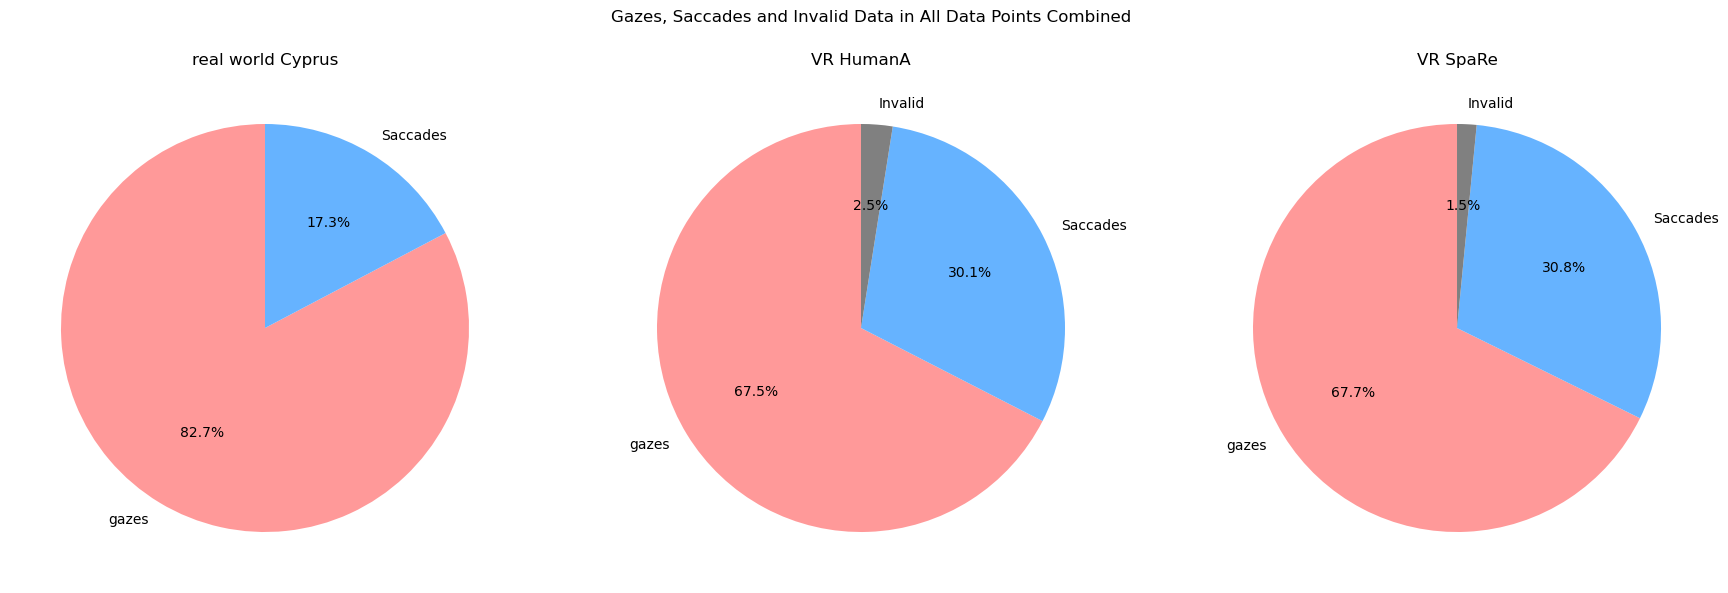

In [38]:
# plot the durations data into pie plots

labelsRW = ['gazes', 'Saccades']
colorsRW = ['#ff9999','#66b3ff']

labelsVR = ['gazes', 'Saccades', 'Invalid']
colorsVR = ['#ff9999','#66b3ff','grey']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plt.subplots_adjust(wspace=0.3)

# First subplot
axes[0].pie(lengthsRW, labels=labelsRW, autopct='%1.1f%%', startangle=90, colors=colorsRW)
axes[0].set_title('real world Cyprus')

# Second subplot
axes[1].pie(lengthsHA, labels=labelsVR, autopct='%1.1f%%', startangle=90, colors=colorsVR)
axes[1].set_title('VR HumanA')

# Third subplot
axes[2].pie(lengthsSR, labels=labelsVR, autopct='%1.1f%%', startangle=90, colors=colorsVR)
axes[2].set_title('VR SpaRe')

plt.suptitle('Gazes, Saccades and Invalid Data in All Data Points Combined')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle

# Uncomment these lines if you want to save:
full_save_path = os.path.join(savepath, 'eyeMovement_piePlots.png')

plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

plt.show()

In [39]:
blink_sum_allSamples = sum(count_blink_rows) 
blink_sum_isFix_samples =  sum(count_blink_isFix)
blink_sum_notFix_samples =  sum(count_blink_notFix)

blink_sum_allDurs = sum(durs_blink_rows) 
blink_sum_isFix_durs =  sum(durs_blink_isFix)
blink_sum_notFix_durs =  sum(durs_blink_notFix)

# optional sanity check
print(blink_sum_allSamples)
print(blink_sum_isFix_samples + blink_sum_notFix_samples)

print(blink_sum_allDurs)
print(blink_sum_isFix_durs + blink_sum_notFix_durs)

188486
188486
945642528000.0
945642528000.0


In [40]:
# Blink durations (convert from ns to ms)
blink_sum_isFix_durs_ms = blink_sum_isFix_durs / 1e6      # ms
blink_sum_notFix_durs_ms = blink_sum_notFix_durs / 1e6    # ms
blink_total_ms = blink_sum_isFix_durs_ms + blink_sum_notFix_durs_ms

In [41]:
# Your existing sums (in ms)
gaze_sum = sum(fixationDurations)           # ms
saccade_sum = sum(saccadeDurations)         # ms

# Blink durations (convert from ns to ms)
blink_sum_isFix_durs_ms = blink_sum_isFix_durs / 1e6      # ms
blink_sum_notFix_durs_ms = blink_sum_notFix_durs / 1e6    # ms
blink_total_ms = blink_sum_isFix_durs_ms + blink_sum_notFix_durs_ms

print(blink_total_ms)
print(blink_sum_allDurs / 1e6 )

# Durations with blink intervals removed
fixations_wo_blinks = gaze_sum - blink_sum_isFix_durs_ms
saccades_wo_blinks = saccade_sum - blink_sum_notFix_durs_ms

pieRW_lengths = [fixations_wo_blinks, saccades_wo_blinks, blink_total_ms]

945642.528
945642.528


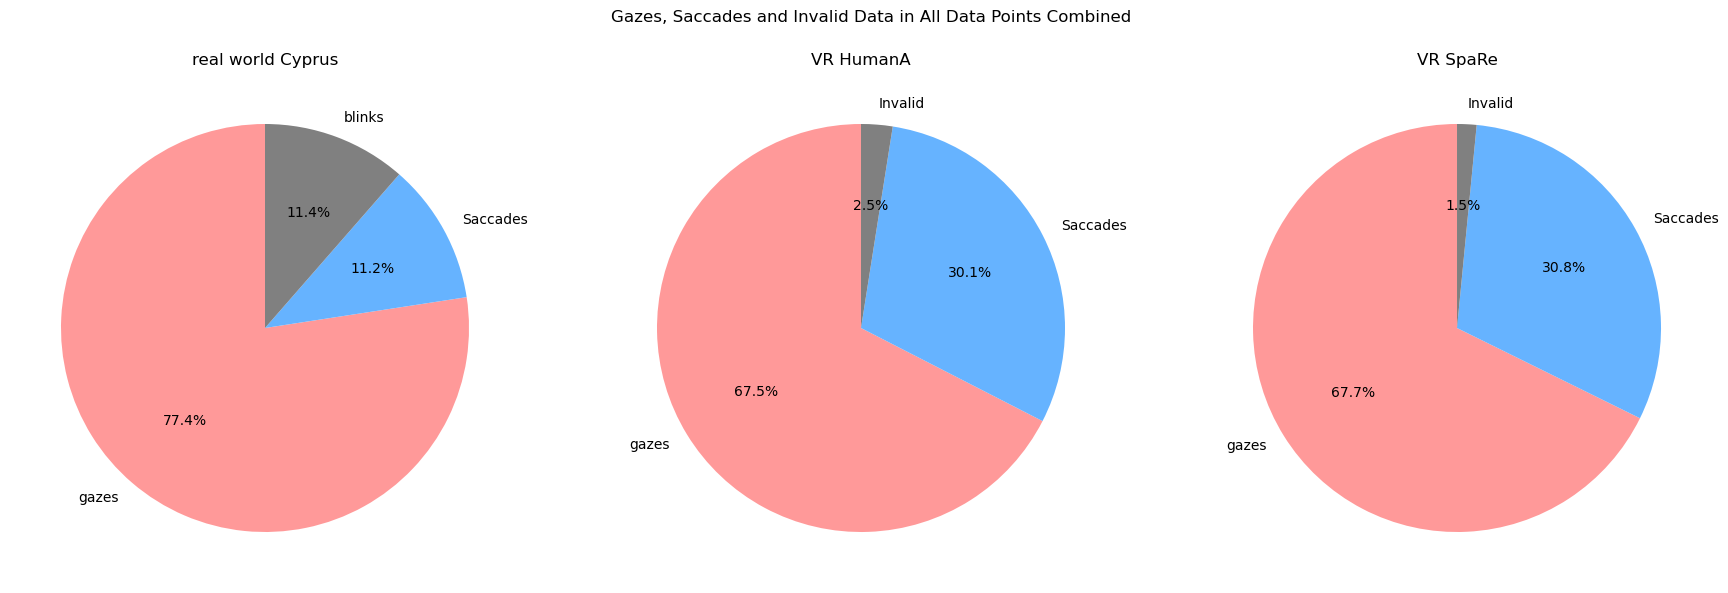

In [42]:
# plot the durations data into pie plots

labelsRW = ['gazes', 'Saccades', 'blinks']
colorsRW = ['#ff9999','#66b3ff','grey']

labelsVR = ['gazes', 'Saccades', 'Invalid']
colorsVR = ['#ff9999','#66b3ff','grey']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plt.subplots_adjust(wspace=0.3)

# First subplot
axes[0].pie(pieRW_lengths, labels=labelsRW, autopct='%1.1f%%', startangle=90, colors=colorsRW)
axes[0].set_title('real world Cyprus')

# Second subplot
axes[1].pie(lengthsHA, labels=labelsVR, autopct='%1.1f%%', startangle=90, colors=colorsVR)
axes[1].set_title('VR HumanA')

# Third subplot
axes[2].pie(lengthsSR, labels=labelsVR, autopct='%1.1f%%', startangle=90, colors=colorsVR)
axes[2].set_title('VR SpaRe')

plt.suptitle('Gazes, Saccades and Invalid Data in All Data Points Combined')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle

# # Uncomment these lines if you want to save:
full_save_path = os.path.join(savepath, 'eyeMovement_piePlotsBlinks.png')

plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

plt.show()

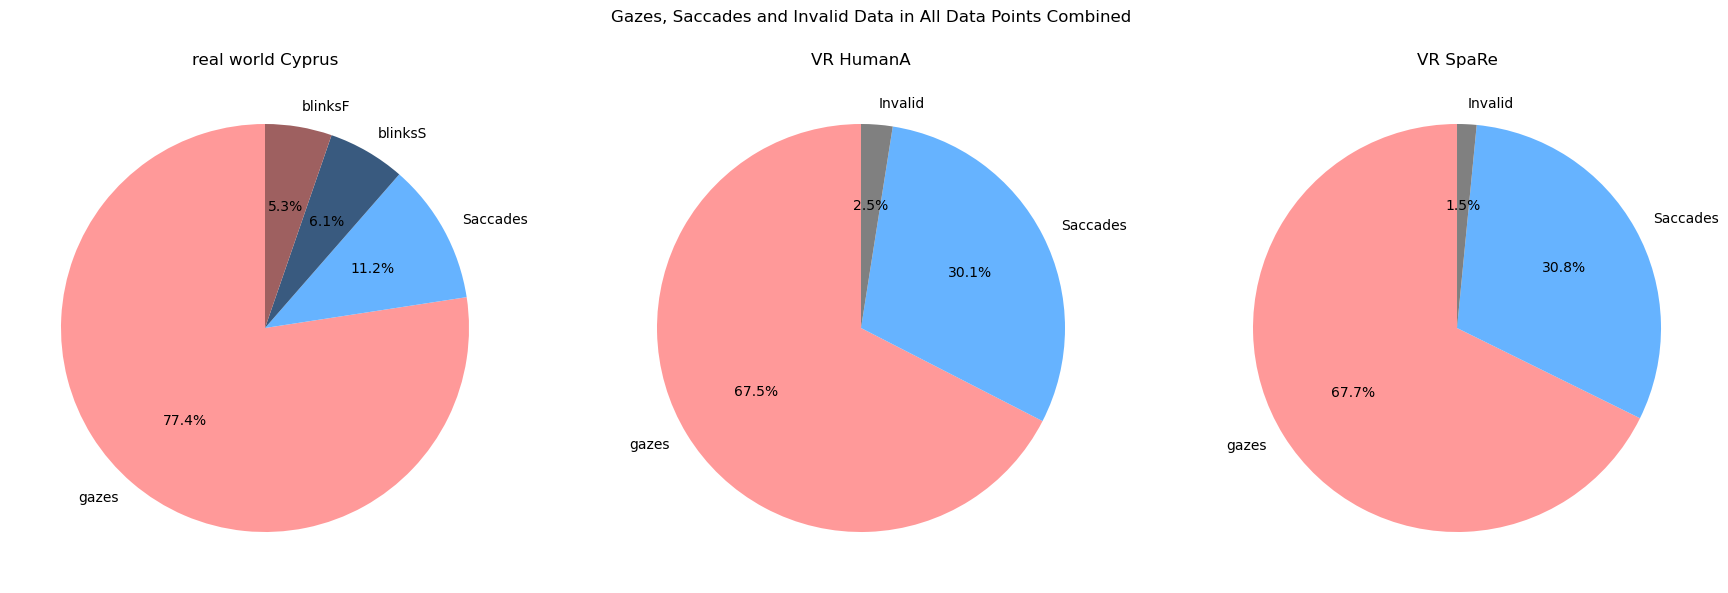

In [43]:
# plot the durations data into pie plots

pieRW_lengthsSeparate = [fixations_wo_blinks, saccades_wo_blinks,  blink_sum_notFix_durs_ms, blink_sum_isFix_durs_ms, ]

labelsRW = ['gazes', 'Saccades', 'blinksS', 'blinksF']
colorsRW = ['#ff9999','#66b3ff','#395a7fff','#9e6060ff']

labelsVR = ['gazes', 'Saccades', 'Invalid']
colorsVR = ['#ff9999','#66b3ff','grey']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plt.subplots_adjust(wspace=0.3)

# First subplot
axes[0].pie(pieRW_lengthsSeparate, labels=labelsRW, autopct='%1.1f%%', startangle=90, colors=colorsRW)
axes[0].set_title('real world Cyprus')

# Second subplot
axes[1].pie(lengthsHA, labels=labelsVR, autopct='%1.1f%%', startangle=90, colors=colorsVR)
axes[1].set_title('VR HumanA')

# Third subplot
axes[2].pie(lengthsSR, labels=labelsVR, autopct='%1.1f%%', startangle=90, colors=colorsVR)
axes[2].set_title('VR SpaRe')

plt.suptitle('Gazes, Saccades and Invalid Data in All Data Points Combined')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle

# # Uncomment these lines if you want to save:
full_save_path = os.path.join(savepath, 'eyeMovement_piePlots_blinksSeparate.png')

plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

plt.show()